# Notebook 07: Tool Usage Patterns Analysis (Phase 7a)

**Purpose**: Explore AI tool usage patterns and their relationship to AIRS constructs  
**Research Questions**: RQ9 - Which AI tools are most widely used? Do usage patterns relate to AI readiness?  
**Sample**: N=472 complete cases  
**Method**: Descriptive statistics, correlation analysis, ANOVA comparisons

## Overview

This analysis examines:
1. **Tool Usage Frequency**: Which AI tools are most widely adopted?
2. **Usage Profiles**: Single-tool vs. multi-tool users
3. **Role Patterns**: Do professionals and students prefer different tools?
4. **AIRS Relationships**: How does tool usage correlate with readiness constructs?

## Data Source

**Input**: `AIRS_clean.csv` (output from previous notebooks)  
**Tool Variables**: Usage_MSCopilot, Usage_ChatGPT, Usage_Gemini, Usage_Other (1-5 scale)  
**AIRS Variables**: 12-item validated scale + additional constructs from full survey

---
## 0. Setup and Configuration

In [163]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configure APA-style visualization settings (300 DPI, publication-ready)
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed for reproducibility
np.random.seed(67)

print("="*70)
print("NOTEBOOK 07: TOOL USAGE PATTERNS ANALYSIS (PHASE 7a)")
print("="*70)
print("\n[OK] Environment configured")
print("   - Visualization: APA style (300 DPI)")
print("   - Random seed: 67 (consistent with previous phases)")

NOTEBOOK 07: TOOL USAGE PATTERNS ANALYSIS (PHASE 7a)

[OK] Environment configured
   - Visualization: APA style (300 DPI)
   - Random seed: 67 (consistent with previous phases)


In [164]:
# Load full dataset
df = pd.read_csv('../data/AIRS_clean.csv')

# Define tool usage variables
tool_vars = ['Usage_MSCopilot', 'Usage_ChatGPT', 'Usage_Gemini', 'Usage_Other']
tool_labels = ['MS Copilot', 'ChatGPT', 'Google Gemini', 'Other AI Tools']

print("="*70)
print("DATA LOADING")
print("="*70)
print(f"\n[OK] Dataset loaded: N = {len(df)}")
print(f"[OK] Variables: {df.shape[1]} columns")

print(f"\n[TOOL USAGE VARIABLES]")
for var, label in zip(tool_vars, tool_labels):
    if var in df.columns:
        print(f"   ✓ {var} ({label})")
    else:
        print(f"   ✗ {var} - NOT FOUND")
        
print("\n" + "="*70)

DATA LOADING

[OK] Dataset loaded: N = 481
[OK] Variables: 45 columns

[TOOL USAGE VARIABLES]
   ✓ Usage_MSCopilot (MS Copilot)
   ✓ Usage_ChatGPT (ChatGPT)
   ✓ Usage_Gemini (Google Gemini)
   ✓ Usage_Other (Other AI Tools)



---
## 1. Load and Verify Data

Load full dataset and confirm tool usage variables are present.

In [165]:
# Descriptive statistics for each tool
print("="*70)
print("DESCRIPTIVE STATISTICS: TOOL USAGE")
print("="*70)

# Create summary table
desc_stats = pd.DataFrame({
    'Tool': tool_labels,
    'Mean': [df[var].mean() for var in tool_vars],
    'SD': [df[var].std() for var in tool_vars],
    'Median': [df[var].median() for var in tool_vars],
    'Min': [df[var].min() for var in tool_vars],
    'Max': [df[var].max() for var in tool_vars],
    'N_Valid': [df[var].notna().sum() for var in tool_vars]
})

print("\n[SUMMARY STATISTICS]")
print(desc_stats.to_string(index=False))

# Rank tools by mean usage
desc_stats_sorted = desc_stats.sort_values('Mean', ascending=False)
print("\n[TOOL USAGE RANKING BY MEAN]")
for i, (idx, row) in enumerate(desc_stats_sorted.iterrows(), 1):
    print(f"   {i}. {row['Tool']}: M={row['Mean']:.2f}, SD={row['SD']:.2f}")
    
print("\n" + "="*70)

DESCRIPTIVE STATISTICS: TOOL USAGE

[SUMMARY STATISTICS]
          Tool     Mean       SD  Median  Min  Max  N_Valid
    MS Copilot 2.463617 1.378113     2.0    1    5      481
       ChatGPT 2.989605 1.429560     3.0    1    5      481
 Google Gemini 2.453222 1.379310     2.0    1    5      481
Other AI Tools 1.968815 1.218377     1.0    1    5      481

[TOOL USAGE RANKING BY MEAN]
   1. ChatGPT: M=2.99, SD=1.43
   2. MS Copilot: M=2.46, SD=1.38
   3. Google Gemini: M=2.45, SD=1.38
   4. Other AI Tools: M=1.97, SD=1.22



---
## 2. Descriptive Statistics: Tool Usage Patterns

Calculate means, standard deviations, and frequency distributions for each AI tool. Identify which tools are most widely adopted and rank by mean usage.

In [166]:
# Frequency distributions (1-5 scale: Never → Daily)
print("="*70)
print("FREQUENCY DISTRIBUTIONS (1-5 SCALE)")
print("="*70)

scale_labels = ['1=Never', '2=Rarely', '3=Sometimes', '4=Often', '5=Daily']

freq_table = pd.DataFrame()
for var, label in zip(tool_vars, tool_labels):
    counts = df[var].value_counts(normalize=True).sort_index() * 100
    freq_table[label] = counts

freq_table.index = scale_labels
print("\n[PERCENTAGE DISTRIBUTIONS]")
print(freq_table.round(1))

# Calculate "active users" (3+ = Sometimes or more frequent)
print("\n[ACTIVE USERS: SOMETIMES/OFTEN/DAILY (3-5 on scale)]")
for var, label in zip(tool_vars, tool_labels):
    active_pct = (df[var] >= 3).sum() / len(df) * 100
    active_n = (df[var] >= 3).sum()
    print(f"   {label}: {active_n} ({active_pct:.1f}%)")
    
print("\n" + "="*70)

FREQUENCY DISTRIBUTIONS (1-5 SCALE)

[PERCENTAGE DISTRIBUTIONS]
             MS Copilot  ChatGPT  Google Gemini  Other AI Tools
1=Never            37.0     24.3           37.0            53.2
2=Rarely           15.8     12.5           16.0            15.6
3=Sometimes        20.2     20.2           21.8            15.8
4=Often            17.9     26.0           15.0            11.9
5=Daily             9.1     17.0           10.2             3.5

[ACTIVE USERS: SOMETIMES/OFTEN/DAILY (3-5 on scale)]
   MS Copilot: 227 (47.2%)
   ChatGPT: 304 (63.2%)
   Google Gemini: 226 (47.0%)
   Other AI Tools: 150 (31.2%)




[CREATING VISUALIZATION]


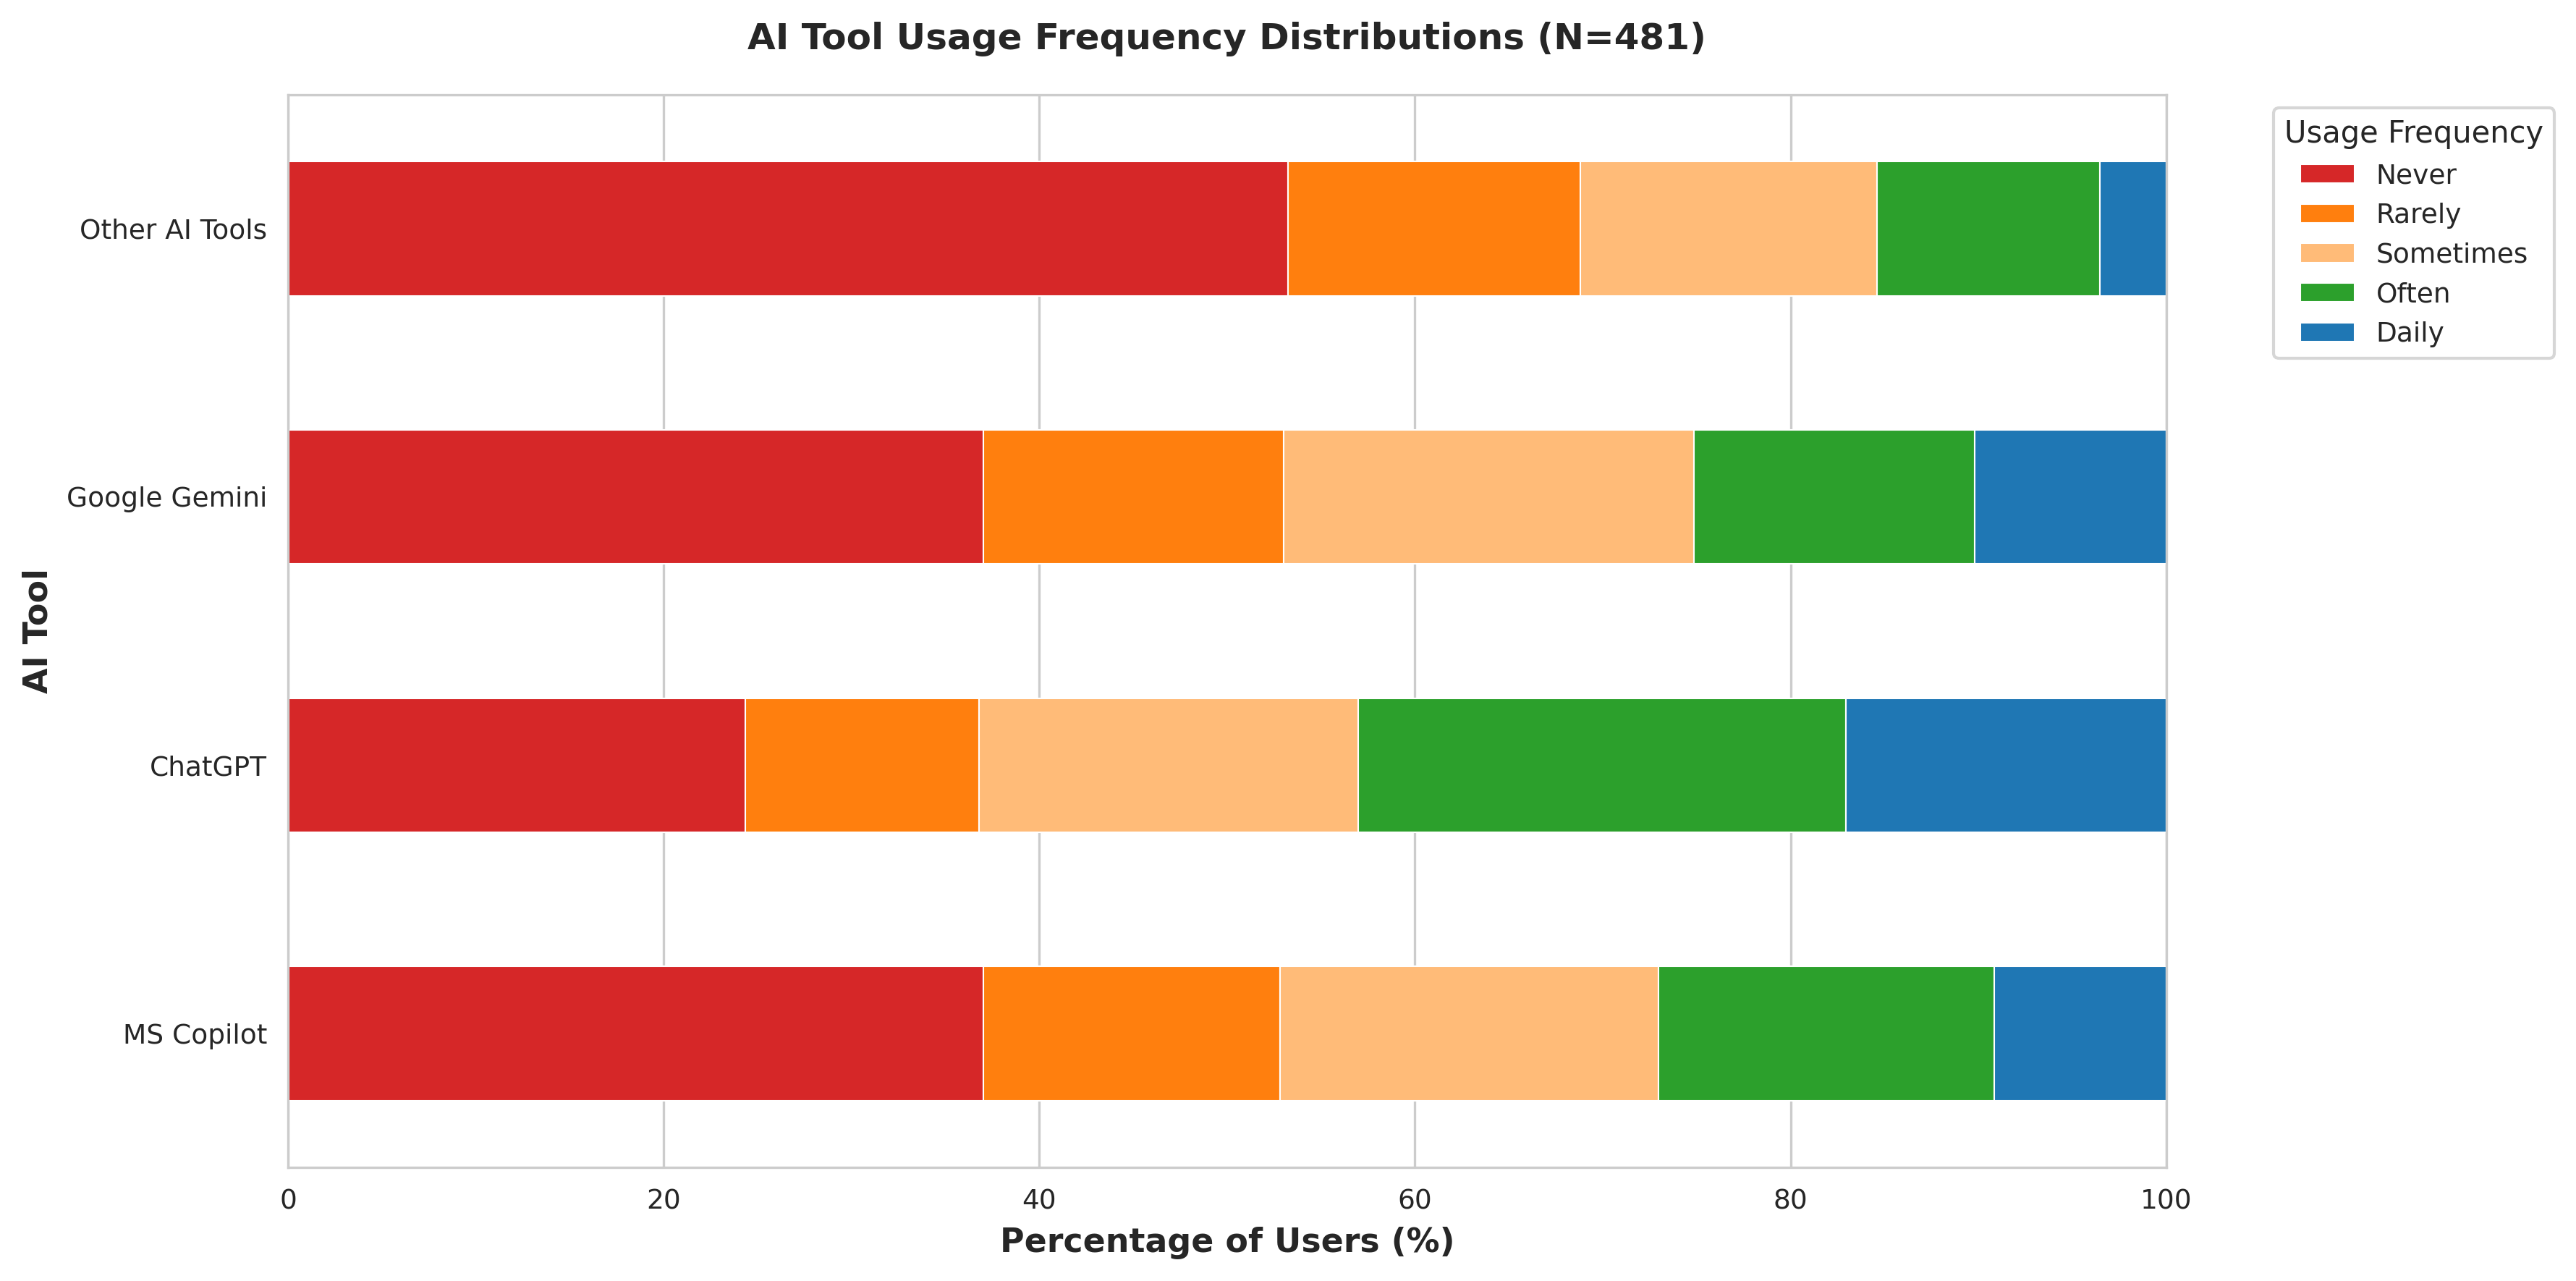

✓ Figure 1 saved: results/plots/07_tool_usage_distributions.png


In [167]:
# Figure 1: Stacked bar chart showing frequency distributions
print("\n[CREATING VISUALIZATION]")

# Ensure output directory exists
Path('../results/plots').mkdir(parents=True, exist_ok=True)

fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for stacked bars
freq_data = pd.DataFrame()
for var in tool_vars:
    freq_data[var] = df[var].value_counts(normalize=True).sort_index() * 100

freq_data.index = ['Never', 'Rarely', 'Sometimes', 'Often', 'Daily']
freq_data.columns = tool_labels

# APA-style color scheme (red-to-blue gradient)
colors = ['#d62728', '#ff7f0e', '#ffbb78', '#2ca02c', '#1f77b4']

# Plot stacked horizontal bar chart
freq_data.T.plot(kind='barh', stacked=True, ax=ax, color=colors,
                 edgecolor='white', linewidth=0.5)

ax.set_xlabel('Percentage of Users (%)', fontsize=11, fontweight='bold')
ax.set_ylabel('AI Tool', fontsize=11, fontweight='bold')
ax.set_title(f'AI Tool Usage Frequency Distributions (N={len(df)})', 
             fontsize=12, fontweight='bold', pad=15)
ax.legend(title='Usage Frequency', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.set_xlim(0, 100)

plt.tight_layout()
plt.savefig('../results/plots/07_tool_usage_distributions.png', bbox_inches='tight', dpi=300)
plt.show()

print("✓ Figure 1 saved: results/plots/07_tool_usage_distributions.png")

---
## 3. Usage Profiles: Single-Tool vs. Multi-Tool Users

Classify users by number of active tools (3+ on usage scale) and analyze profile distribution.

In [168]:
# Define "active use" as 3+ on 1-5 scale (Sometimes or more)
df['Active_MSCopilot'] = (df['Usage_MSCopilot'] >= 3).astype(int)
df['Active_ChatGPT'] = (df['Usage_ChatGPT'] >= 3).astype(int)
df['Active_Gemini'] = (df['Usage_Gemini'] >= 3).astype(int)
df['Active_Other'] = (df['Usage_Other'] >= 3).astype(int)

# Count number of tools actively used
df['Num_Tools_Active'] = (df['Active_MSCopilot'] + df['Active_ChatGPT'] + 
                          df['Active_Gemini'] + df['Active_Other'])

# Create usage profile categories
df['Usage_Profile'] = pd.cut(df['Num_Tools_Active'], 
                              bins=[-0.5, 0.5, 1.5, 4.5],
                              labels=['Non-User', 'Single-Tool', 'Multi-Tool'])

# Profile distribution
profile_counts = df['Usage_Profile'].value_counts()
profile_pcts = df['Usage_Profile'].value_counts(normalize=True) * 100

print("\n=== Tool Usage Profiles ===")
print(f"Non-Users (0 tools): {profile_counts['Non-User']} ({profile_pcts['Non-User']:.1f}%)")
print(f"Single-Tool Users (1 tool): {profile_counts['Single-Tool']} ({profile_pcts['Single-Tool']:.1f}%)")
print(f"Multi-Tool Users (2+ tools): {profile_counts['Multi-Tool']} ({profile_pcts['Multi-Tool']:.1f}%)")

# Mean tools actively used
print(f"\nMean active tools per user: M={df['Num_Tools_Active'].mean():.2f}, SD={df['Num_Tools_Active'].std():.2f}")


=== Tool Usage Profiles ===
Non-Users (0 tools): 98 (20.4%)
Single-Tool Users (1 tool): 107 (22.2%)
Multi-Tool Users (2+ tools): 276 (57.4%)

Mean active tools per user: M=1.89, SD=1.39



[CREATING VISUALIZATION]


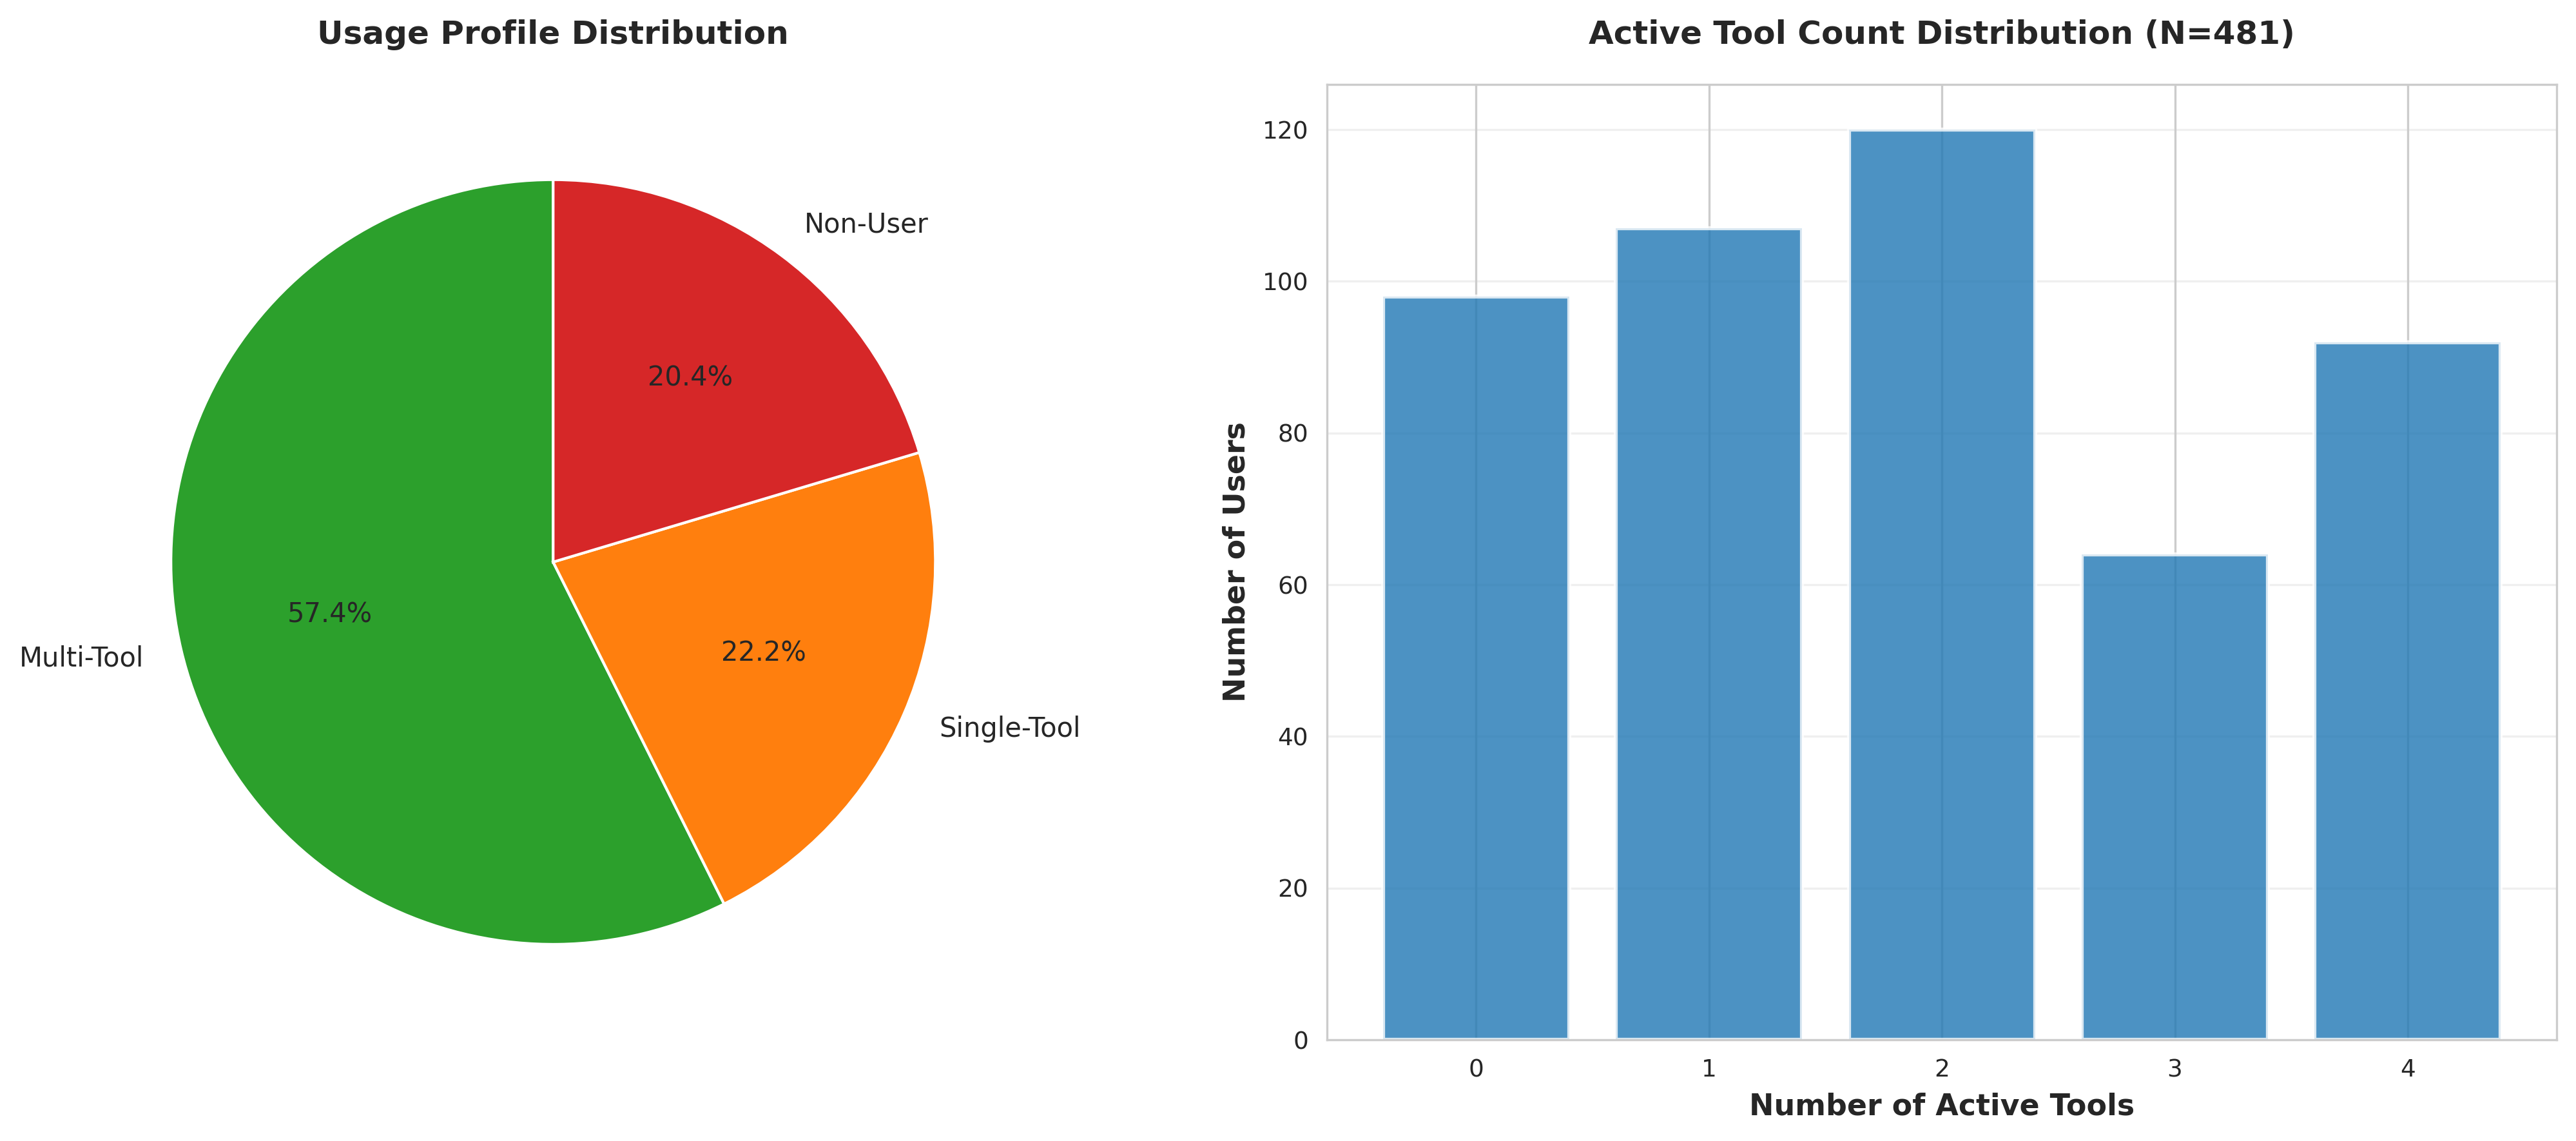

✓ Figure 2 saved: results/plots/07_tool_usage_profiles.png


In [169]:
# Figure 2: Usage profile distribution visualization
print("\n[CREATING VISUALIZATION]")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart: Usage profile distribution
if 'Usage_Profile' in df.columns:
    profile_counts = df['Usage_Profile'].value_counts()
    colors_pie = ['#2ca02c', '#ff7f0e', '#d62728']
    ax1.pie(profile_counts, labels=profile_counts.index, autopct='%1.1f%%',
            colors=colors_pie, startangle=90, textprops={'fontsize': 10})
    ax1.set_title('Usage Profile Distribution', fontsize=12, fontweight='bold', pad=15)

# Bar chart: Tool count distribution  
if 'Num_Tools_Active' in df.columns:
    tool_count_dist = df['Num_Tools_Active'].value_counts().sort_index()
    ax2.bar(tool_count_dist.index, tool_count_dist.values, color='#1f77b4', 
            edgecolor='white', linewidth=1.5, alpha=0.8)
    ax2.set_xlabel('Number of Active Tools', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Number of Users', fontsize=11, fontweight='bold')
    ax2.set_title(f'Active Tool Count Distribution (N={len(df)})', fontsize=12, fontweight='bold', pad=15)
    ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/07_tool_usage_profiles.png', bbox_inches='tight', dpi=300)
plt.show()

print("✓ Figure 2 saved: results/plots/07_tool_usage_profiles.png")

---
## 4. Role-Based Tool Preferences

Examine whether professional roles show different tool usage patterns.

In [170]:
# Tool usage by Role (Student vs. Professional)
print("\n=== Tool Usage by Role ===")
for var, label in zip(tool_vars, tool_labels):
    role_means = df.groupby('Role')[var].agg(['mean', 'std', 'count'])
    print(f"\n{label}:")
    print(role_means)
    
    # T-test
    student = df[df['Role'] == 'Student'][var].dropna()
    professional = df[df['Role'] == 'Professional'][var].dropna()
    t_stat, p_val = stats.ttest_ind(student, professional)
    print(f"  t({len(student)+len(professional)-2}) = {t_stat:.3f}, p = {p_val:.4f}")
    if p_val < 0.05:
        higher_group = 'Students' if student.mean() > professional.mean() else 'Professionals'
        print(f"  ✓ {higher_group} use {label} significantly more (p<.05)")


=== Tool Usage by Role ===

MS Copilot:
                                       mean       std  count
Role                                                        
Employed - executive or leader     3.566038  1.217018     53
Employed - individual contributor  2.018868  1.257216    106
Employed - manager                 3.464789  1.240173     71
Freelancer or self employed        1.666667  1.154701     30
Full time student                  2.226744  1.214332    172
Not currently employed             2.428571  1.342460     14
Other                              1.909091  1.150945     22
Part time student                  2.076923  1.441153     13
  t(-2) = nan, p = nan

ChatGPT:
                                       mean       std  count
Role                                                        
Employed - executive or leader     3.452830  1.380719     53
Employed - individual contributor  2.179245  1.255822    106
Employed - manager                 3.309859  1.379353     71
Freelancer 


[CREATING VISUALIZATION]


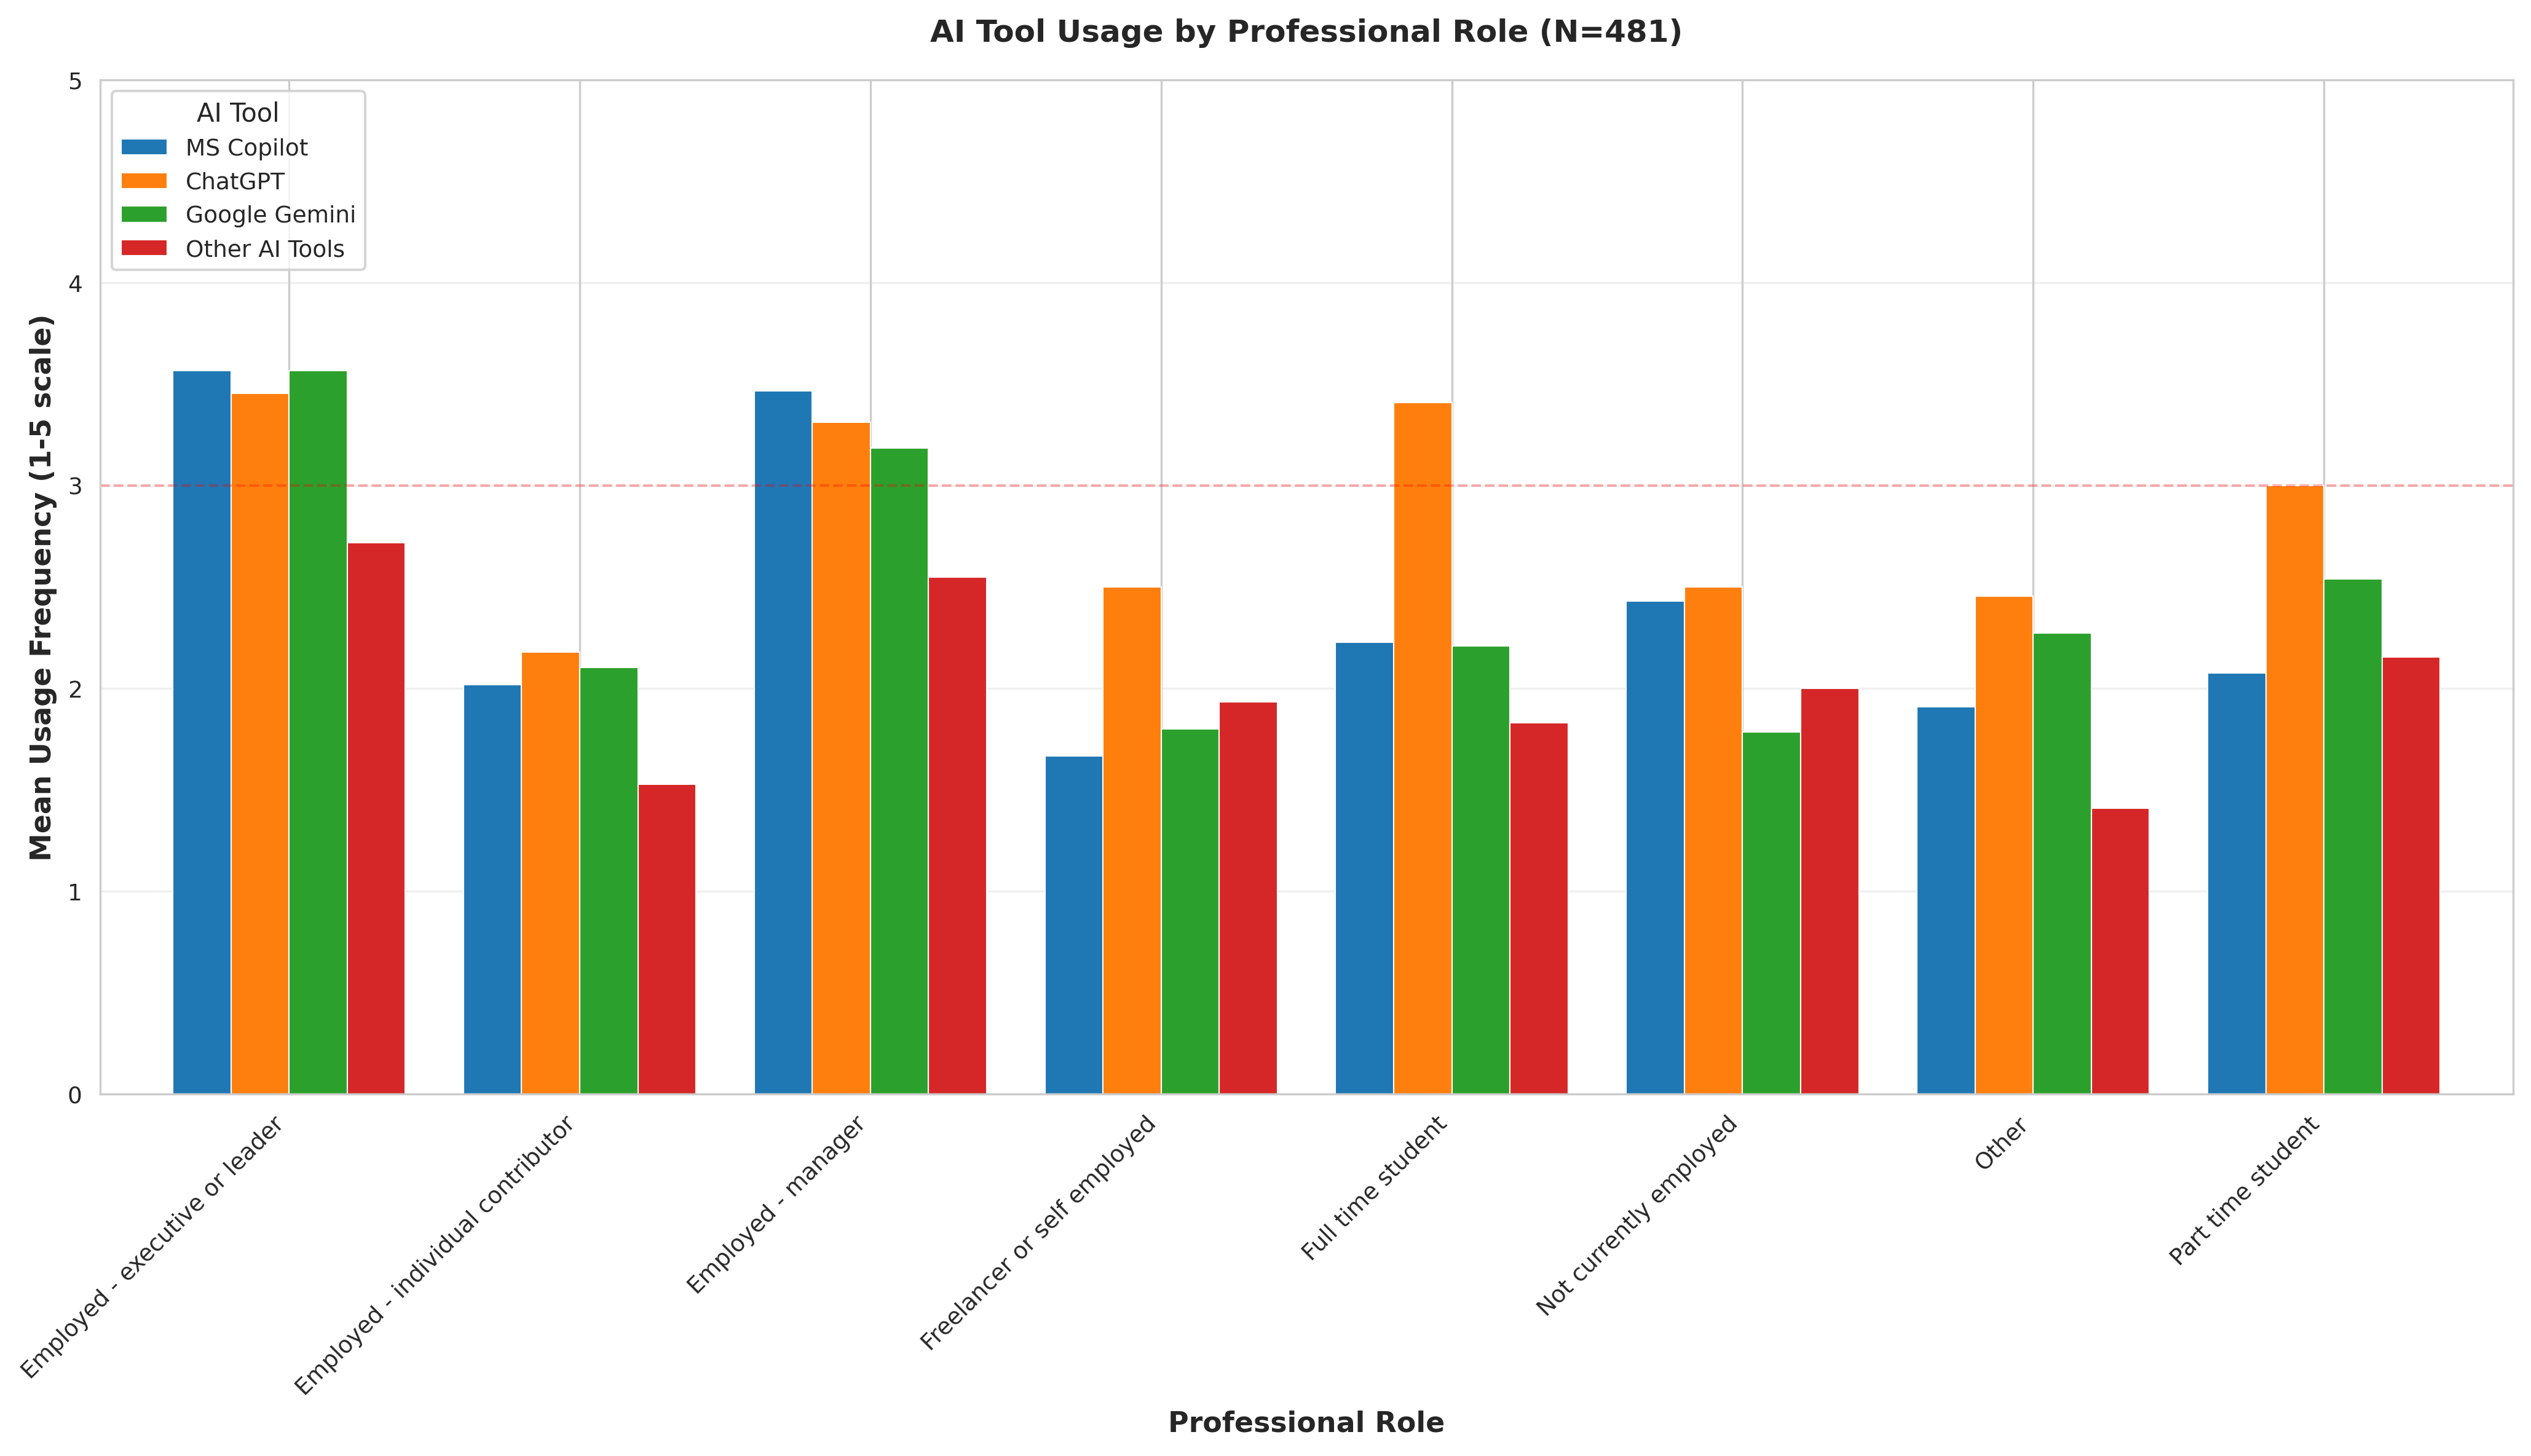

✓ Figure 3 saved: results/plots/07_tool_usage_by_role.png


In [171]:
# Figure 3: Tool usage by role (grouped bar chart)
print("\n[CREATING VISUALIZATION]")

fig, ax = plt.subplots(figsize=(14, 8))

# Calculate mean tool usage by role
if 'Role' in df.columns:
    role_tool_means = pd.DataFrame()
    for var, label in zip(tool_vars, tool_labels):
        role_tool_means[label] = df.groupby('Role')[var].mean()
    
    # Plot grouped bar chart
    role_tool_means.plot(kind='bar', ax=ax, width=0.8, 
                         color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
                         edgecolor='white', linewidth=0.5)
    
    ax.set_xlabel('Professional Role', fontsize=11, fontweight='bold')
    ax.set_ylabel('Mean Usage Frequency (1-5 scale)', fontsize=11, fontweight='bold')
    ax.set_title(f'AI Tool Usage by Professional Role (N={len(df)})', 
                 fontsize=12, fontweight='bold', pad=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend(title='AI Tool', loc='upper left', fontsize=9)
    ax.set_ylim(0, 5)
    ax.grid(axis='y', alpha=0.3)
    ax.axhline(3, color='red', linestyle='--', alpha=0.3, linewidth=1, label='Active Use Threshold')

plt.tight_layout()
plt.savefig('../results/plots/07_tool_usage_by_role.png', bbox_inches='tight', dpi=300)
plt.show()

print("✓ Figure 3 saved: results/plots/07_tool_usage_by_role.png")

In [172]:
# Tool usage by Education level
if 'Education' in df.columns:
    print("\n=== Tool Usage by Education Level ===")
    
    # Define education labels
    edu_labels = {1: 'High School', 2: 'Some College', 3: "Associate's", 
                  4: "Bachelor's", 5: "Master's", 6: 'Doctoral'}
    df['Education_Label'] = df['Education'].map(edu_labels)
    
    for var, label in zip(tool_vars, tool_labels):
        edu_means = df.groupby('Education_Label')[var].agg(['mean', 'count'])
        print(f"\n{label}:")
        print(edu_means)
        
        # ANOVA
        groups = [df[df['Education'] == i][var].dropna() for i in range(1, 7)]
        groups = [g for g in groups if len(g) > 0]  # Remove empty groups
        if len(groups) > 2:
            f_stat, p_val = stats.f_oneway(*groups)
            print(f"  F({len(groups)-1}, {sum(len(g) for g in groups)-len(groups)}) = {f_stat:.3f}, p = {p_val:.4f}")
else:
    print("\n⚠️ Education variable not found in dataset")


=== Tool Usage by Education Level ===

MS Copilot:
Empty DataFrame
Columns: [mean, count]
Index: []

ChatGPT:
Empty DataFrame
Columns: [mean, count]
Index: []

Google Gemini:
Empty DataFrame
Columns: [mean, count]
Index: []

Other AI Tools:
Empty DataFrame
Columns: [mean, count]
Index: []


In [173]:
# Tool usage by Industry (top 5 industries)
if 'Industry' in df.columns:
    print("\n=== Tool Usage by Industry (Top 5 Industries) ===")
    
    # Identify top 5 industries by sample size
    top_industries = df['Industry'].value_counts().head(5).index
    df_top_ind = df[df['Industry'].isin(top_industries)]
    
    for var, label in zip(tool_vars, tool_labels):
        ind_means = df_top_ind.groupby('Industry')[var].agg(['mean', 'count']).sort_values('mean', ascending=False)
        print(f"\n{label}:")
        print(ind_means)
else:
    print("\n⚠️ Industry variable not found in dataset")


=== Tool Usage by Industry (Top 5 Industries) ===

MS Copilot:
                           mean  count
Industry                              
Technology or IT       3.482143     56
Healthcare             2.333333     57
Education              2.285714     70
Retail or Hospitality  2.222222     45
Other                  2.165680    169

ChatGPT:
                           mean  count
Industry                              
Technology or IT       3.928571     56
Education              3.085714     70
Healthcare             2.947368     57
Other                  2.781065    169
Retail or Hospitality  2.577778     45

Google Gemini:
                           mean  count
Industry                              
Technology or IT       3.375000     56
Retail or Hospitality  2.355556     45
Healthcare             2.298246     57
Other                  2.260355    169
Education              2.157143     70

Other AI Tools:
                           mean  count
Industry                           

---
## 5. Tool Usage Correlations with AIRS Constructs

Examine relationships between tool usage frequency and AI readiness dimensions.

In [174]:
# Correlations between tool usage and AIRS constructs
airs_constructs = ['PE2', 'EE1', 'SI1', 'FC1', 'HM2', 'PV2', 'HB2', 'VO1', 
                   'TR2', 'EX1', 'ER2', 'AX1', 'BI']
construct_labels = ['PE', 'EE', 'SI', 'FC', 'HM', 'PV', 'HB', 'VO', 
                    'TR', 'EX', 'ER', 'AX', 'BI']

# Check if BI is mean of 4 items or single item
if 'BI' not in df.columns and all(f'BI{i}' in df.columns for i in range(1, 5)):
    df['BI'] = df[['BI1', 'BI2', 'BI3', 'BI4']].mean(axis=1)
    print("✓ Created BI composite from BI1-BI4")

# Compute correlations
corr_matrix = pd.DataFrame(index=tool_labels, columns=construct_labels)

for tool_var, tool_label in zip(tool_vars, tool_labels):
    for airs_var, airs_label in zip(airs_constructs, construct_labels):
        if airs_var in df.columns:
            r, p = stats.pearsonr(df[tool_var].dropna(), df[airs_var].dropna())
            # Mark significant correlations
            if p < 0.001:
                corr_matrix.loc[tool_label, airs_label] = f"{r:.3f}***"
            elif p < 0.01:
                corr_matrix.loc[tool_label, airs_label] = f"{r:.3f}**"
            elif p < 0.05:
                corr_matrix.loc[tool_label, airs_label] = f"{r:.3f}*"
            else:
                corr_matrix.loc[tool_label, airs_label] = f"{r:.3f}"

print("\n=== Tool Usage Correlations with AIRS Constructs ===")
print(corr_matrix)
print("\nNote: *p<.05, **p<.01, ***p<.001")

✓ Created BI composite from BI1-BI4

=== Tool Usage Correlations with AIRS Constructs ===
                      PE        EE        SI        FC        HM        PV  \
MS Copilot      0.494***  0.373***  0.510***  0.383***  0.470***  0.394***   
ChatGPT         0.517***  0.525***  0.449***  0.423***  0.512***  0.526***   
Google Gemini   0.459***  0.366***  0.423***  0.369***  0.480***  0.456***   
Other AI Tools  0.424***  0.360***  0.415***  0.396***  0.458***  0.415***   

                      HB        VO        TR        EX         ER         AX  \
MS Copilot      0.422***  0.425***  0.429***  0.383***    -0.113*  -0.227***   
ChatGPT         0.556***  0.589***  0.539***  0.362***  -0.179***  -0.237***   
Google Gemini   0.430***  0.483***  0.454***  0.415***   -0.132**  -0.252***   
Other AI Tools  0.432***  0.444***  0.388***  0.361***     -0.086  -0.198***   

                      BI  
MS Copilot      0.528***  
ChatGPT         0.579***  
Google Gemini   0.527***  
Other AI T


[CREATING VISUALIZATION]


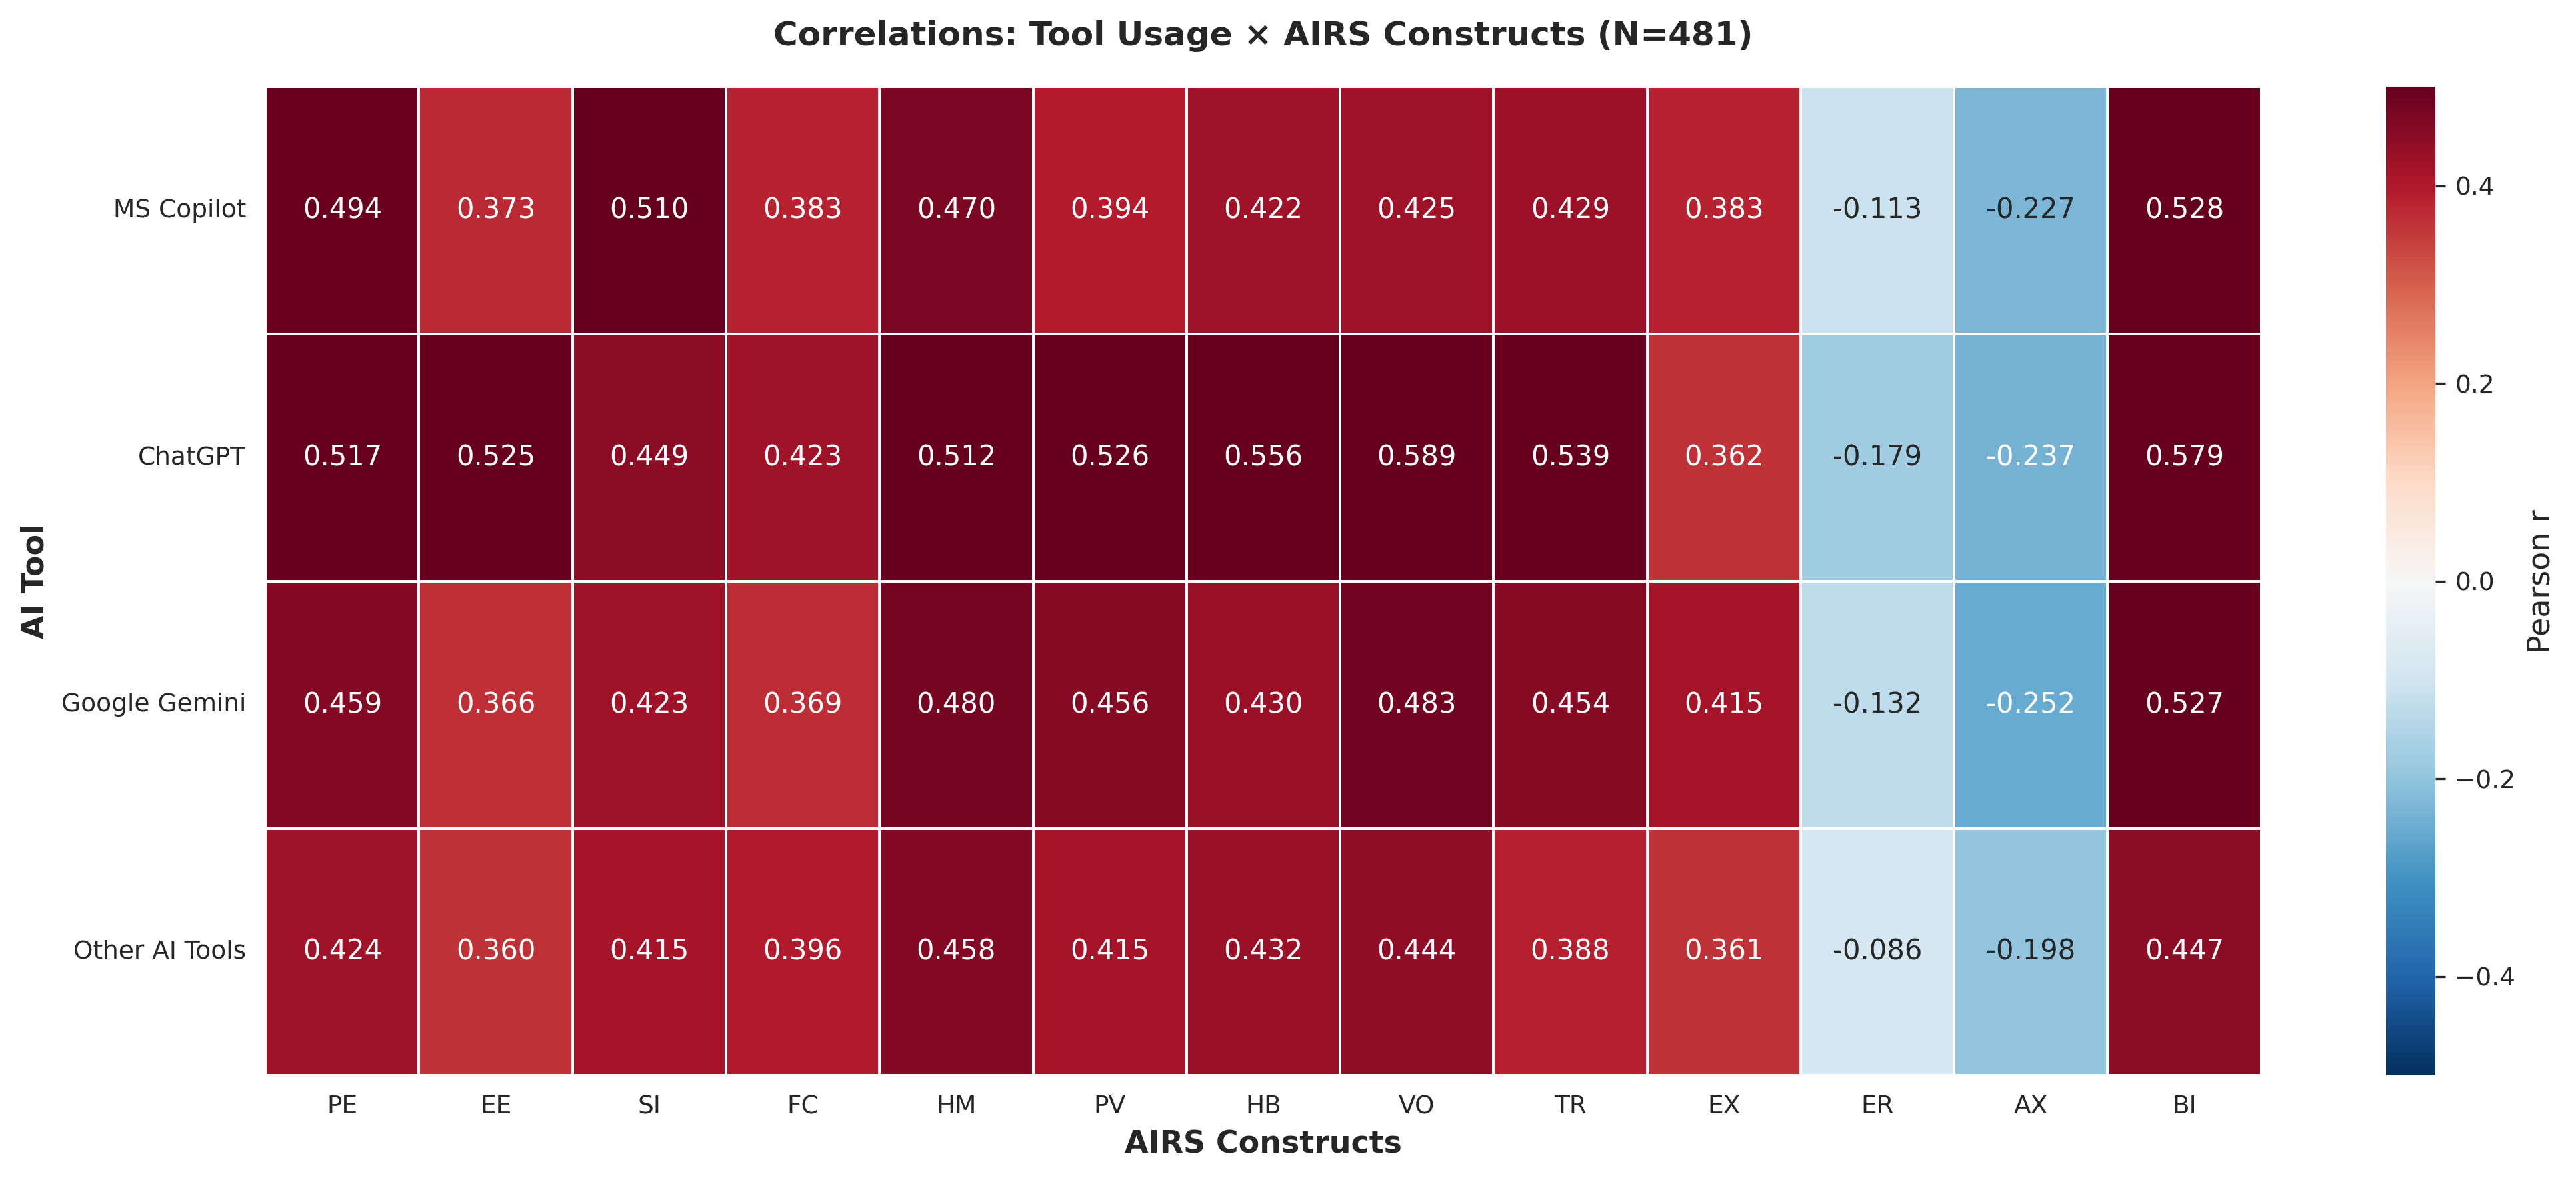

✓ Figure 4 saved: results/plots/07_tool_construct_correlations.png
Note: *p<.05, **p<.01, ***p<.001


In [175]:
# Figure 4: Heatmap of tool-construct correlations
print("\n[CREATING VISUALIZATION]")

fig, ax = plt.subplots(figsize=(14, 6))

# Extract numeric correlations for heatmap
if 'corr_matrix' in locals():
    corr_numeric = corr_matrix.applymap(lambda x: float(str(x).replace('*', '')) if pd.notna(x) else 0)
    
    # Plot heatmap
    sns.heatmap(corr_numeric.astype(float), annot=True, fmt='.3f', cmap='RdBu_r', 
                center=0, vmin=-0.5, vmax=0.5, cbar_kws={'label': 'Pearson r'},
                linewidths=0.5, ax=ax)
    
    ax.set_xlabel('AIRS Constructs', fontsize=11, fontweight='bold')
    ax.set_ylabel('AI Tool', fontsize=11, fontweight='bold')
    ax.set_title(f'Correlations: Tool Usage × AIRS Constructs (N={len(df)})', 
                 fontsize=12, fontweight='bold', pad=15)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('../results/plots/07_tool_construct_correlations.png', bbox_inches='tight', dpi=300)
plt.show()

print("✓ Figure 4 saved: results/plots/07_tool_construct_correlations.png")
print("Note: *p<.05, **p<.01, ***p<.001")

---
## 6. Usage Profile Comparison: AIRS Construct Differences

Compare AIRS construct means across usage profiles (Non-User, Single-Tool, Multi-Tool) using ANOVA.

In [176]:
# Compare AIRS constructs across usage profiles
print("\n=== AIRS Constructs by Usage Profile ===")

profile_comparison = pd.DataFrame()
for airs_var, airs_label in zip(airs_constructs, construct_labels):
    if airs_var in df.columns:
        profile_means = df.groupby('Usage_Profile')[airs_var].mean()
        profile_comparison[airs_label] = profile_means

print(profile_comparison.round(3))

# ANOVA for each construct
print("\n=== ANOVA: Usage Profile Effects on AIRS Constructs ===")
for airs_var, airs_label in zip(airs_constructs, construct_labels):
    if airs_var in df.columns:
        groups = [df[df['Usage_Profile'] == prof][airs_var].dropna() 
                  for prof in ['Non-User', 'Single-Tool', 'Multi-Tool']]
        f_stat, p_val = stats.f_oneway(*groups)
        sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
        print(f"{airs_label}: F(2, {sum(len(g) for g in groups)-3}) = {f_stat:.3f}, p = {p_val:.4f} {sig}")


=== AIRS Constructs by Usage Profile ===
                  PE     EE     SI     FC     HM     PV     HB     VO     TR  \
Usage_Profile                                                                  
Non-User       2.051  2.694  2.122  2.357  2.061  2.194  1.735  1.847  2.071   
Single-Tool    3.187  3.729  2.869  3.084  3.140  3.383  2.794  3.243  3.206   
Multi-Tool     3.728  4.065  3.417  3.558  3.786  3.812  3.424  4.018  3.696   

                  EX     ER     AX     BI  
Usage_Profile                              
Non-User       2.367  4.143  4.224  1.918  
Single-Tool    3.178  3.869  3.748  3.030  
Multi-Tool     3.670  3.772  3.420  3.639  

=== ANOVA: Usage Profile Effects on AIRS Constructs ===
PE: F(2, 478) = 103.536, p = 0.0000 ***
EE: F(2, 478) = 90.628, p = 0.0000 ***
SI: F(2, 478) = 55.648, p = 0.0000 ***
FC: F(2, 478) = 45.342, p = 0.0000 ***
HM: F(2, 478) = 107.610, p = 0.0000 ***
PV: F(2, 478) = 99.458, p = 0.0000 ***
HB: F(2, 478) = 80.156, p = 0.0000 ***
VO: F


[CREATING VISUALIZATION]


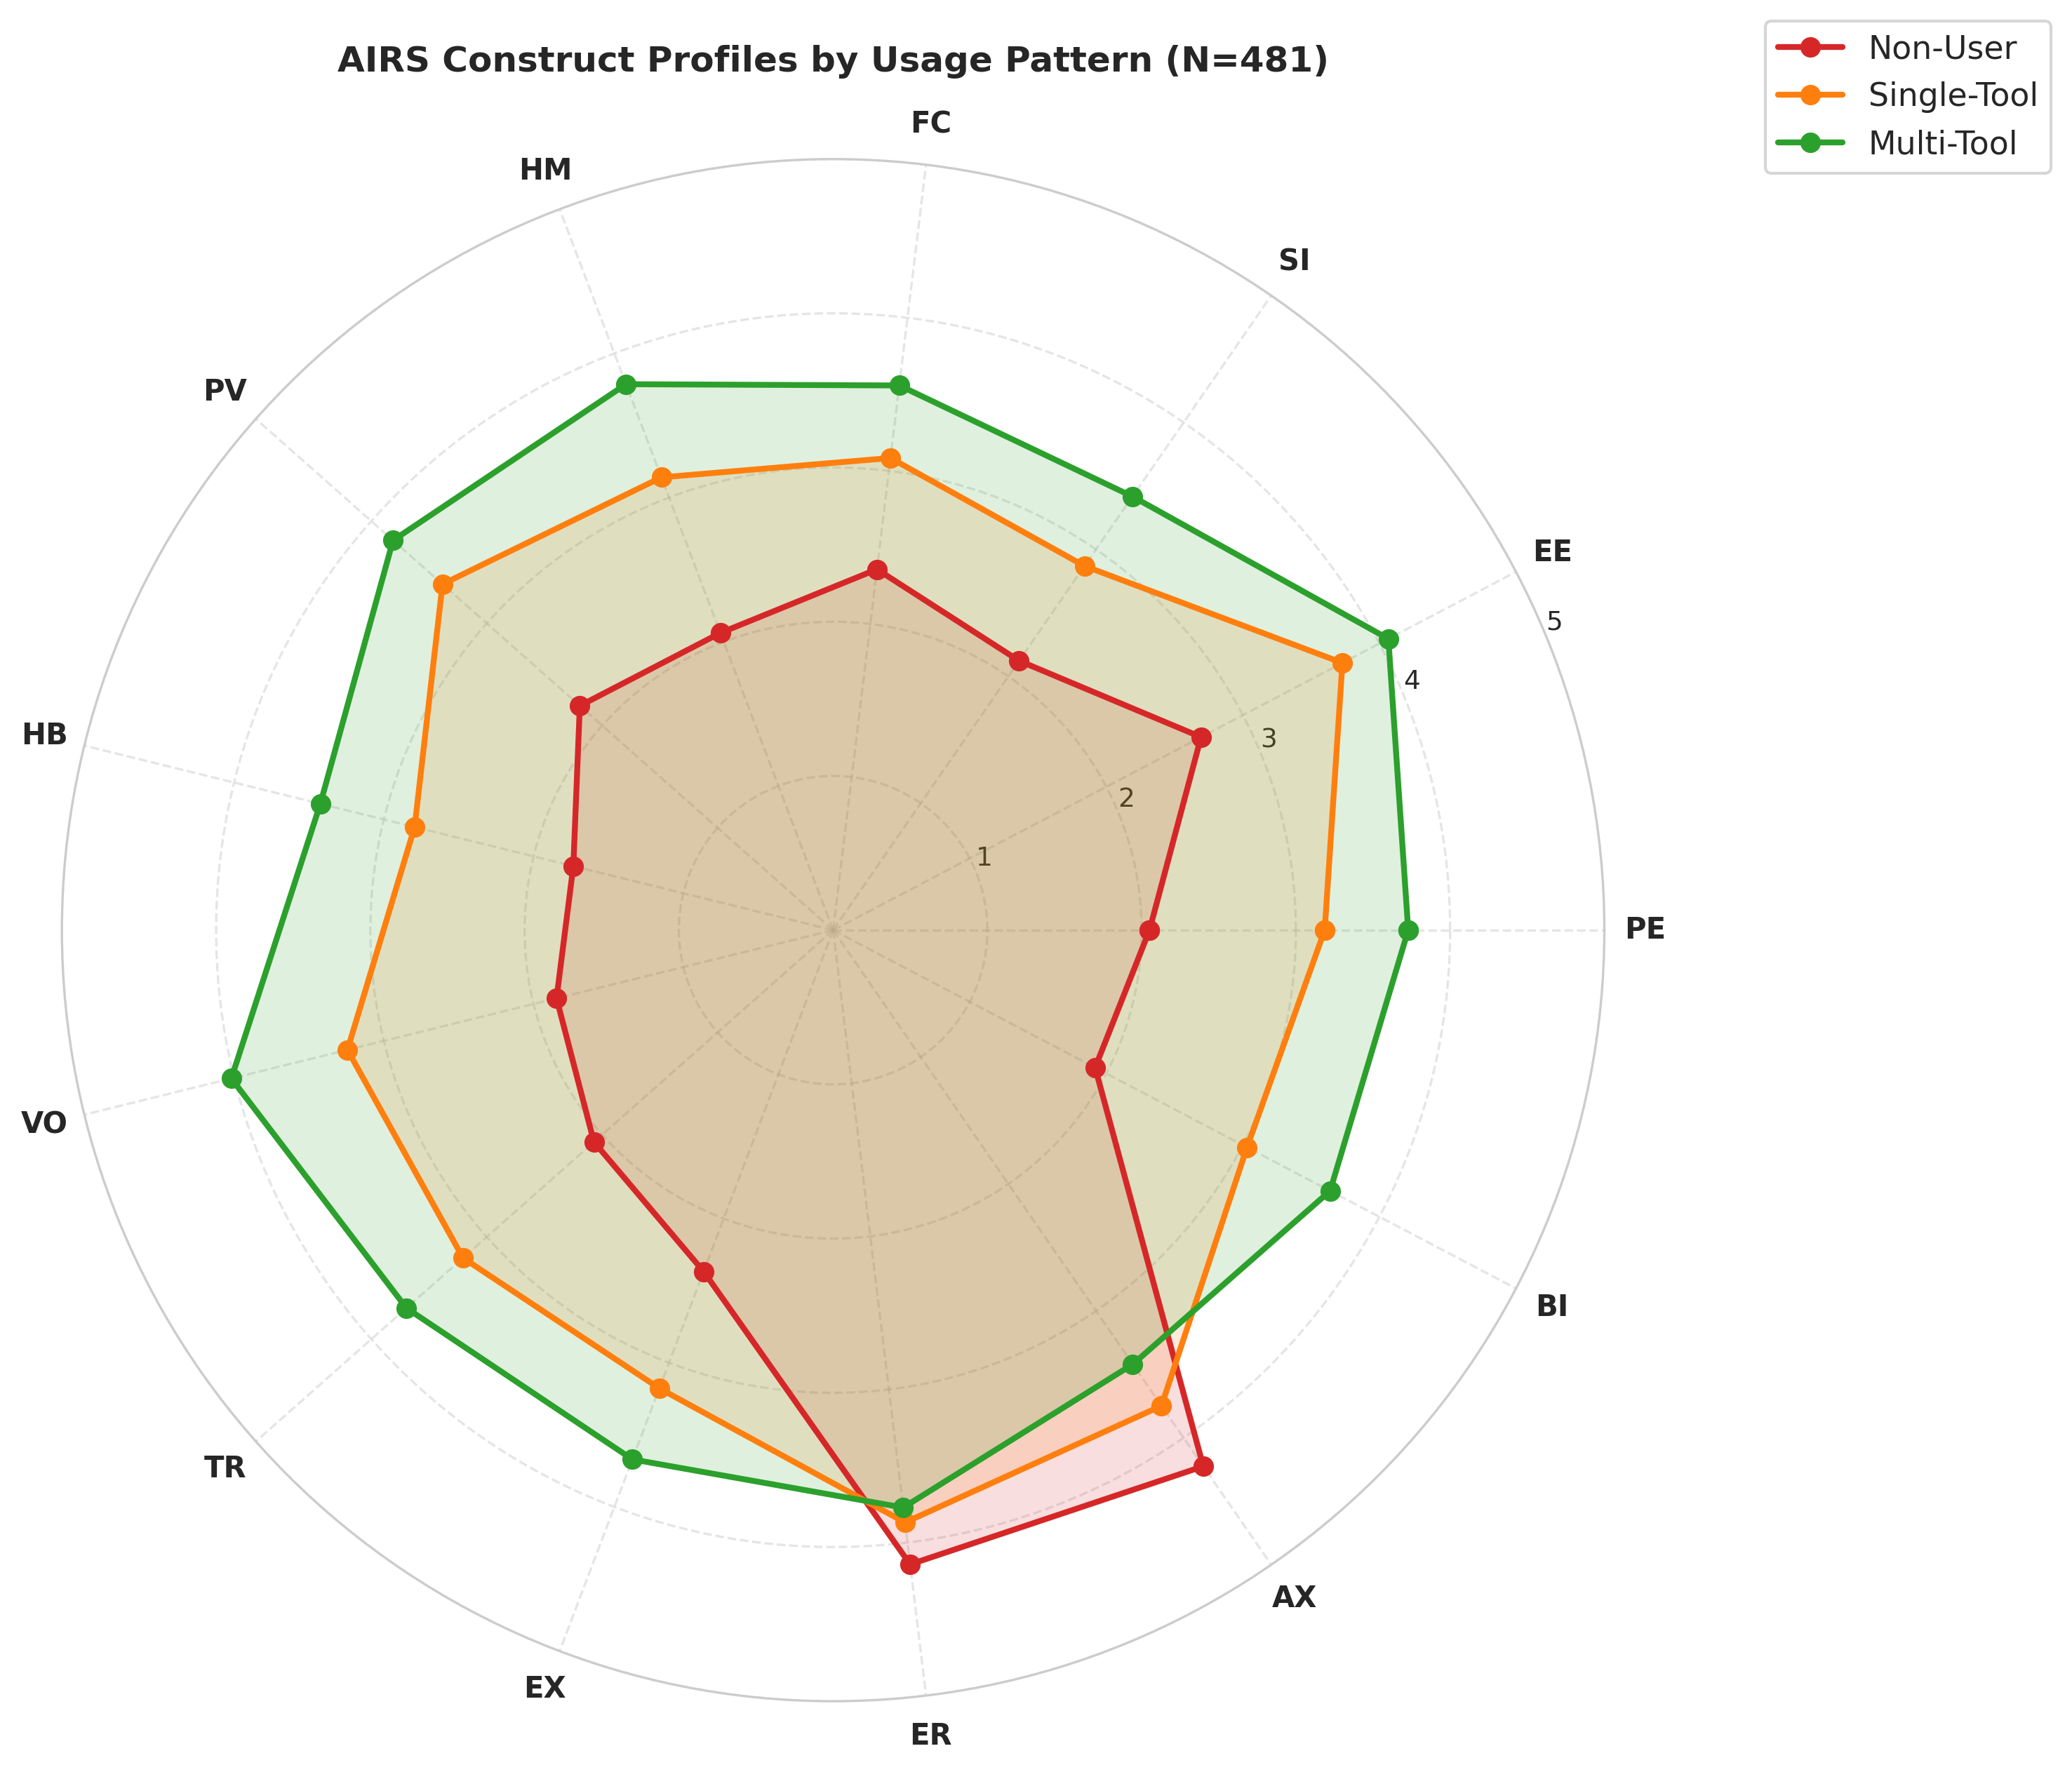

✓ Figure 5 saved: results/plots/07_usage_profile_radar.png


In [177]:
# Figure 5: Radar chart comparing AIRS profiles across usage patterns
print("\n[CREATING VISUALIZATION]")

from math import pi

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

if 'profile_comparison' in locals():
    # Prepare data for radar chart
    categories = list(profile_comparison.columns)
    N = len(categories)
    
    # Compute angles for radar chart
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Plot each profile
    colors = ['#d62728', '#ff7f0e', '#2ca02c']
    profiles = ['Non-User', 'Single-Tool', 'Multi-Tool']
    
    for (profile, color) in zip(profiles, colors):
        if profile in profile_comparison.index:
            values = profile_comparison.loc[profile].tolist()
            values += values[:1]
            ax.plot(angles, values, 'o-', linewidth=2, label=profile, color=color)
            ax.fill(angles, values, alpha=0.15, color=color)
    
    # Formatting
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10, fontweight='bold')
    ax.set_ylim(0, 5)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(['1', '2', '3', '4', '5'], fontsize=9)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
    ax.set_title(f'AIRS Construct Profiles by Usage Pattern (N={len(df)})', 
                 fontsize=12, fontweight='bold', pad=30)

plt.tight_layout()
plt.savefig('../results/plots/07_usage_profile_radar.png', bbox_inches='tight', dpi=300)
plt.show()

print("✓ Figure 5 saved: results/plots/07_usage_profile_radar.png")

---
## 7. Export Summary Tables for Model Tracking

Generate comprehensive results tables for dissertation documentation.

In [178]:
# Export comprehensive summary tables
print("="*70)
print("EXPORTING SUMMARY TABLES")
print("="*70)

# Ensure output directory exists
Path('../results/tables').mkdir(parents=True, exist_ok=True)

# Table 1: Tool Usage Descriptive Statistics
desc_stats.to_csv('../results/tables/07_tool_usage_descriptives.csv', index=False)
print("\n[SAVED] Tool usage descriptive statistics")
print("   → results/tables/07_tool_usage_descriptives.csv")

# Table 2: Usage Profile Distribution
if 'Usage_Profile' in df.columns:
    profile_dist = df['Usage_Profile'].value_counts().reset_index()
    profile_dist.columns = ['Profile', 'N']
    profile_dist['Percentage'] = (profile_dist['N'] / len(df) * 100).round(1)
    profile_dist.to_csv('../results/tables/07_usage_profile_distribution.csv', index=False)
    print("[SAVED] Usage profile distribution")
    print("   → results/tables/07_usage_profile_distribution.csv")

# Table 3: Tool-Construct Correlations
if 'corr_matrix' in locals():
    corr_matrix.to_csv('../results/tables/07_tool_construct_correlations.csv')
    print("[SAVED] Tool-construct correlation matrix")
    print("   → results/tables/07_tool_construct_correlations.csv")

# Table 4: ANOVA Results (Usage Profile Effects)
if 'profile_comparison' in locals():
    profile_comparison.to_csv('../results/tables/07_usage_profile_anova_means.csv')
    print("[SAVED] ANOVA means by usage profile")
    print("   → results/tables/07_usage_profile_anova_means.csv")

# Table 5: Role-Specific Tool Usage
if 'Role' in df.columns:
    role_tool_means = pd.DataFrame()
    for var, label in zip(tool_vars, tool_labels):
        role_tool_means[label] = df.groupby('Role')[var].mean()
    role_tool_means.to_csv('../results/tables/07_role_tool_usage_means.csv')
    print("[SAVED] Role-specific tool usage means")
    print("   → results/tables/07_role_tool_usage_means.csv")

print("\n[OK] All summary tables exported")
print("="*70)

EXPORTING SUMMARY TABLES

[SAVED] Tool usage descriptive statistics
   → results/tables/07_tool_usage_descriptives.csv
[SAVED] Usage profile distribution
   → results/tables/07_usage_profile_distribution.csv
[SAVED] Tool-construct correlation matrix
   → results/tables/07_tool_construct_correlations.csv
[SAVED] ANOVA means by usage profile
   → results/tables/07_usage_profile_anova_means.csv
[SAVED] Role-specific tool usage means
   → results/tables/07_role_tool_usage_means.csv

[OK] All summary tables exported


---
## 9. Supplementary Visualizations

Additional visualizations providing deeper insights into tool usage patterns and their relationship to AIRS constructs.

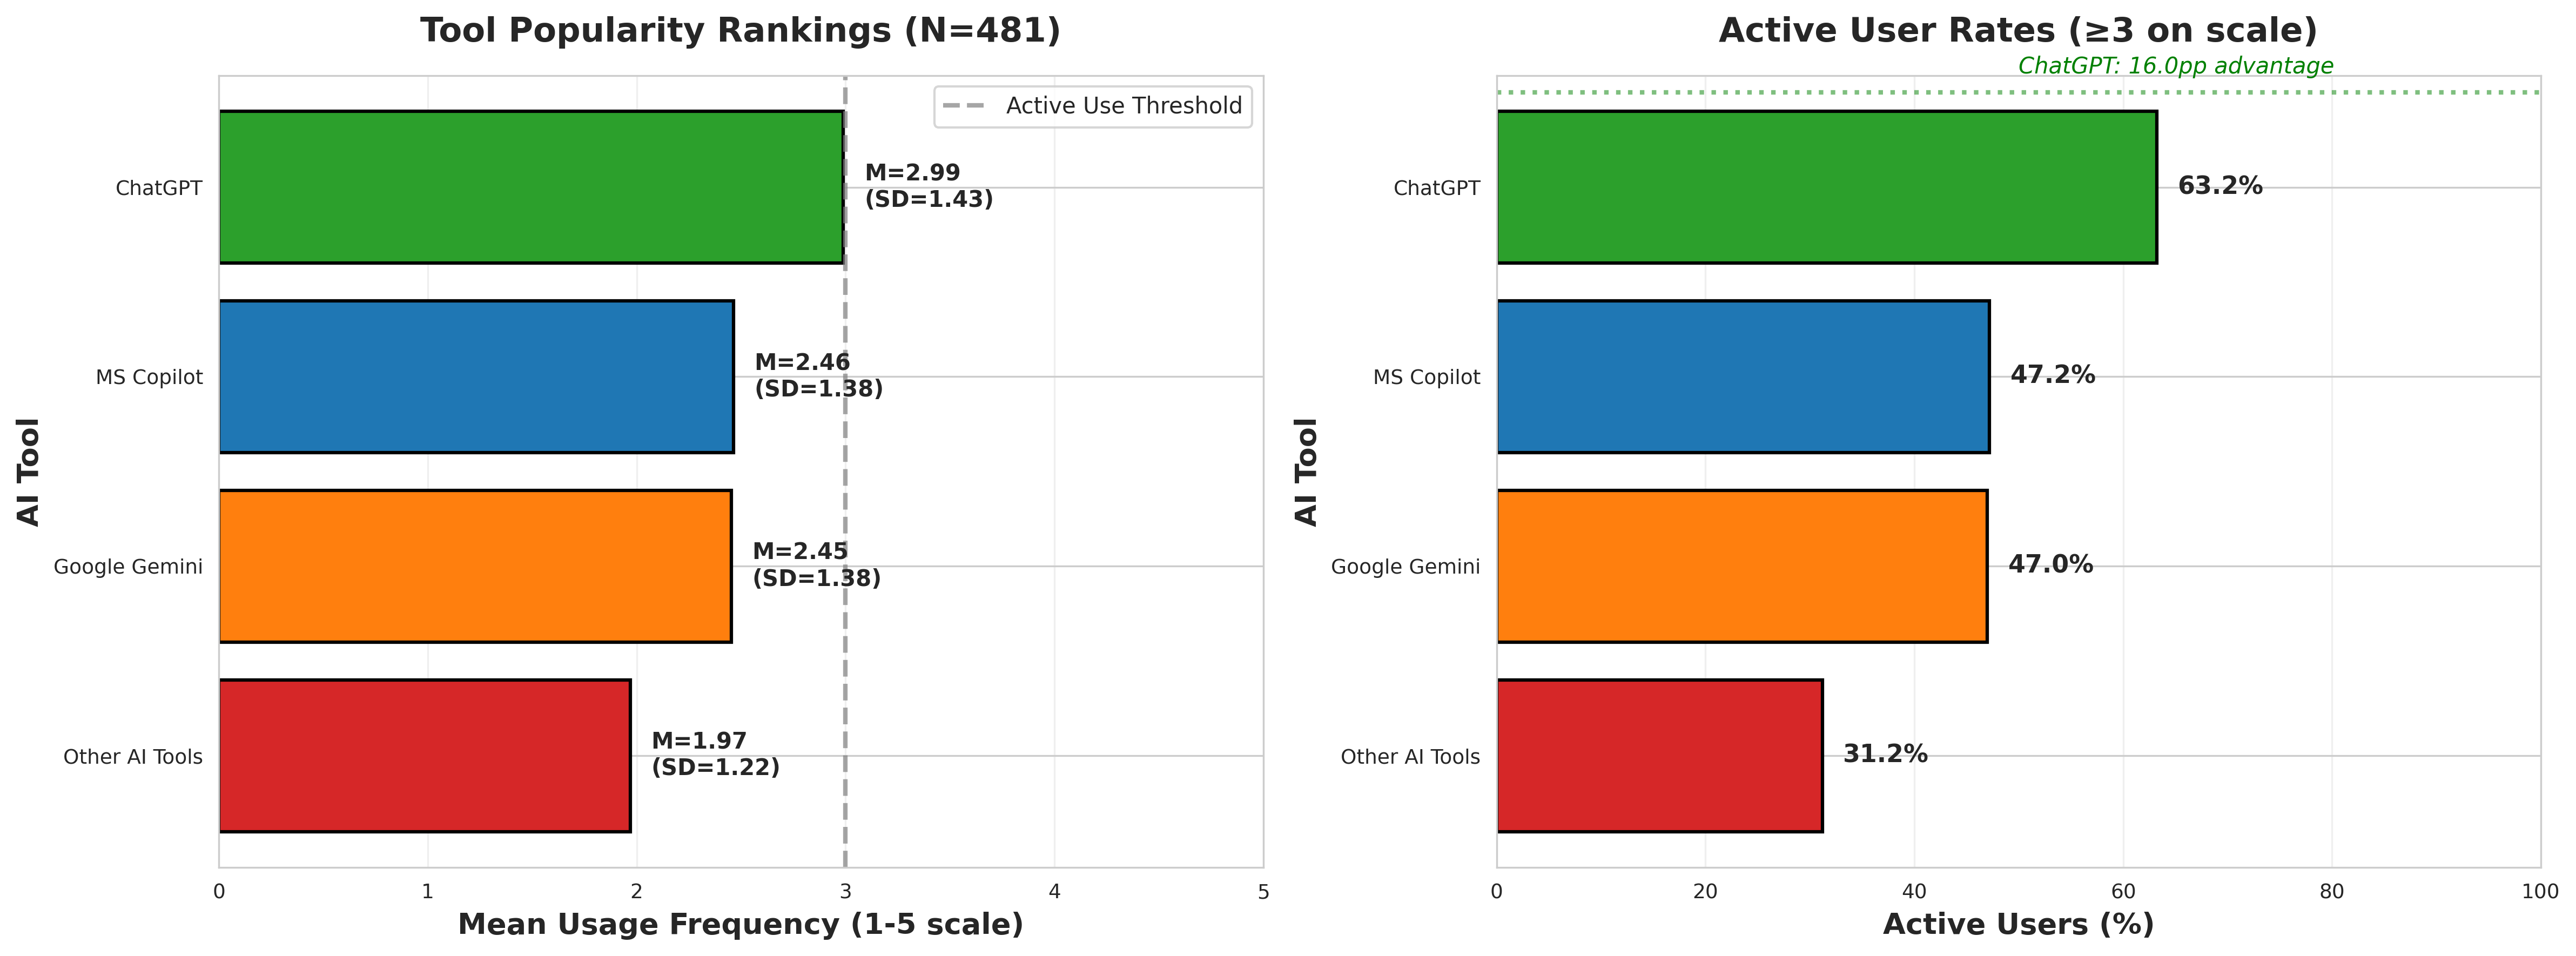


✓ Figure 6 saved: 07_tool_popularity_comparison.png

Tool Usage Ranking:
  1. ChatGPT: 63.2% active users
  2. MS Copilot: 47.2% active users
  3. Google Gemini: 47.0% active users
  4. Other AI Tools: 31.2% active users


In [179]:
# Figure 6: Tool Popularity with Active User Rates
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Panel A: Mean usage scores
tool_means = desc_stats_sorted['Mean'].values
tool_names = desc_stats_sorted['Tool'].values
colors_rank = ['#2ca02c', '#1f77b4', '#ff7f0e', '#d62728']  # Green for #1

bars1 = ax1.barh(tool_names[::-1], tool_means[::-1], color=colors_rank[::-1], edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Mean Usage Frequency (1-5 scale)', fontsize=13, fontweight='bold')
ax1.set_ylabel('AI Tool', fontsize=13, fontweight='bold')
ax1.set_title(f'Tool Popularity Rankings (N={len(df)})', fontsize=15, fontweight='bold', pad=15)
ax1.axvline(3, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='Active Use Threshold')
ax1.set_xlim(0, 5)
ax1.legend(fontsize=10)
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, mean, sd) in enumerate(zip(bars1, tool_means[::-1], desc_stats_sorted['SD'].values[::-1])):
    ax1.text(mean + 0.1, bar.get_y() + bar.get_height()/2, 
             f'M={mean:.2f}\n(SD={sd:.2f})', 
             va='center', fontsize=10, fontweight='bold')

# Panel B: Active user percentages
active_rates = []
for var in tool_vars:
    active_pct = (df[var] >= 3).sum() / len(df) * 100
    active_rates.append(active_pct)

# Reorder by mean usage
tool_order = desc_stats_sorted['Tool'].tolist()
active_rates_ordered = [active_rates[tool_labels.index(t)] for t in tool_order]

bars2 = ax2.barh(tool_names[::-1], active_rates_ordered[::-1], color=colors_rank[::-1], 
                 edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Active Users (%)', fontsize=13, fontweight='bold')
ax2.set_ylabel('AI Tool', fontsize=13, fontweight='bold')
ax2.set_title('Active User Rates (≥3 on scale)', fontsize=15, fontweight='bold', pad=15)
ax2.set_xlim(0, 100)
ax2.grid(axis='x', alpha=0.3)

# Add percentage labels
for bar, rate in zip(bars2, active_rates_ordered[::-1]):
    ax2.text(rate + 2, bar.get_y() + bar.get_height()/2, 
             f'{rate:.1f}%', 
             va='center', fontsize=11, fontweight='bold')

# Highlight top tool advantage (if substantial)
if len(active_rates_ordered) >= 2 and (active_rates_ordered[0] - active_rates_ordered[1]) > 5:
    top_tool = tool_order[0]
    advantage = active_rates_ordered[0] - active_rates_ordered[1]
    ax2.axhline(len(tool_order) - 0.5, color='green', linestyle=':', linewidth=2, alpha=0.5)
    ax2.text(50, len(tool_order) - 0.4, f'{top_tool}: {advantage:.1f}pp advantage', 
             fontsize=10, style='italic', color='green')

plt.tight_layout()
plt.savefig('../results/plots/07_tool_popularity_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

print("\n✓ Figure 6 saved: 07_tool_popularity_comparison.png")
print(f"\nTool Usage Ranking:")
for i, (tool, rate) in enumerate(zip(tool_order, active_rates_ordered), 1):
    print(f"  {i}. {tool}: {rate:.1f}% active users")

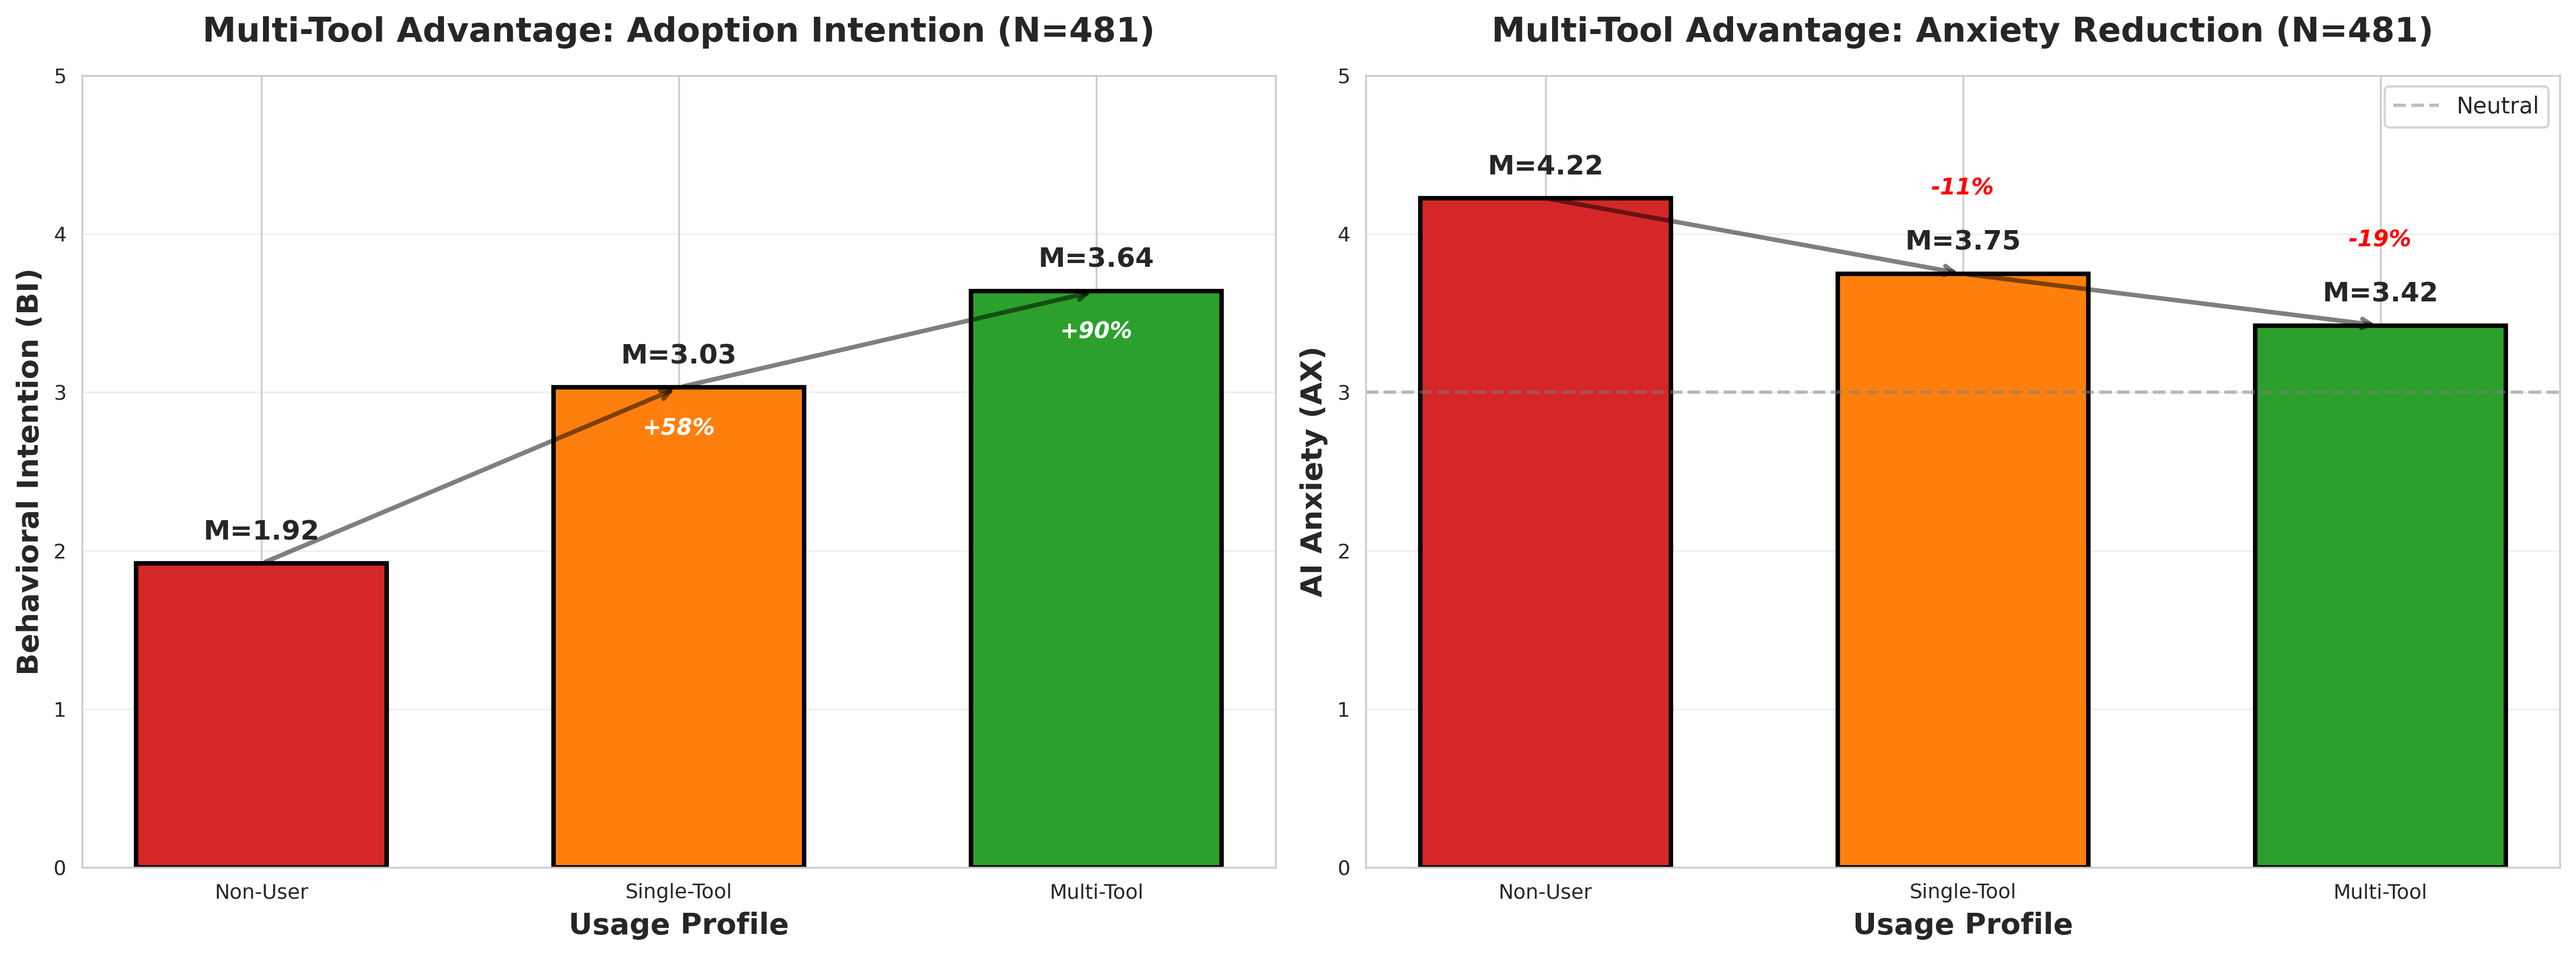


✓ Figure 7 saved: 07_multi_tool_advantage.png

BI Change: Non-Users M=1.92 → Multi-Tool M=3.64 (Δ=1.72)
AX Change: Non-Users M=4.22 → Multi-Tool M=3.42 (Δ=-0.80)


In [180]:
# Figure 7: Multi-Tool Advantage - BI and AX Effects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Panel A: Behavioral Intention by Usage Profile
bi_means = profile_comparison['BI'].values
profiles = profile_comparison.index.tolist()
colors_bi = ['#d62728', '#ff7f0e', '#2ca02c']

bars1 = ax1.bar(profiles, bi_means, color=colors_bi, edgecolor='black', linewidth=2, width=0.6)
ax1.set_ylabel('Behavioral Intention (BI)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Usage Profile', fontsize=13, fontweight='bold')
ax1.set_title(f'Multi-Tool Advantage: Adoption Intention (N={len(df)})', fontsize=15, fontweight='bold', pad=15)
ax1.set_ylim(0, 5)
ax1.grid(axis='y', alpha=0.3)

# Add value labels and percent increase
for i, (bar, mean) in enumerate(zip(bars1, bi_means)):
    ax1.text(bar.get_x() + bar.get_width()/2, mean + 0.15, 
             f'M={mean:.2f}', 
             ha='center', fontsize=12, fontweight='bold')
    if i > 0:
        pct_increase = ((mean - bi_means[0]) / bi_means[0]) * 100
        ax1.text(bar.get_x() + bar.get_width()/2, mean - 0.3, 
                 f'+{pct_increase:.0f}%', 
                 ha='center', fontsize=10, style='italic', color='white', fontweight='bold')

# Arrows showing progression
ax1.annotate('', xy=(1, bi_means[1]), xytext=(0, bi_means[0]),
            arrowprops=dict(arrowstyle='->', lw=2, color='black', alpha=0.5))
ax1.annotate('', xy=(2, bi_means[2]), xytext=(1, bi_means[1]),
            arrowprops=dict(arrowstyle='->', lw=2, color='black', alpha=0.5))

# Panel B: AI Anxiety by Usage Profile
ax_means = profile_comparison['AX'].values

bars2 = ax2.bar(profiles, ax_means, color=colors_bi, edgecolor='black', linewidth=2, width=0.6)
ax2.set_ylabel('AI Anxiety (AX)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Usage Profile', fontsize=13, fontweight='bold')
ax2.set_title(f'Multi-Tool Advantage: Anxiety Reduction (N={len(df)})', fontsize=15, fontweight='bold', pad=15)
ax2.set_ylim(0, 5)
ax2.axhline(3, color='gray', linestyle='--', linewidth=1.5, alpha=0.5, label='Neutral')
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# Add value labels and percent decrease
for i, (bar, mean) in enumerate(zip(bars2, ax_means)):
    ax2.text(bar.get_x() + bar.get_width()/2, mean + 0.15, 
             f'M={mean:.2f}', 
             ha='center', fontsize=12, fontweight='bold')
    if i > 0:
        pct_decrease = ((ax_means[0] - mean) / ax_means[0]) * 100
        ax2.text(bar.get_x() + bar.get_width()/2, mean + 0.5, 
                 f'-{pct_decrease:.0f}%', 
                 ha='center', fontsize=10, style='italic', color='red', fontweight='bold')

# Arrows showing progression
ax2.annotate('', xy=(1, ax_means[1]), xytext=(0, ax_means[0]),
            arrowprops=dict(arrowstyle='->', lw=2, color='black', alpha=0.5))
ax2.annotate('', xy=(2, ax_means[2]), xytext=(1, ax_means[1]),
            arrowprops=dict(arrowstyle='->', lw=2, color='black', alpha=0.5))

plt.tight_layout()
plt.savefig('../results/plots/07_multi_tool_advantage.png', bbox_inches='tight', dpi=300)
plt.show()

print("\n✓ Figure 7 saved: 07_multi_tool_advantage.png")
print(f"\nBI Change: Non-Users M={bi_means[0]:.2f} → Multi-Tool M={bi_means[2]:.2f} (Δ={bi_means[2]-bi_means[0]:.2f})")
print(f"AX Change: Non-Users M={ax_means[0]:.2f} → Multi-Tool M={ax_means[2]:.2f} (Δ={ax_means[2]-ax_means[0]:.2f})")

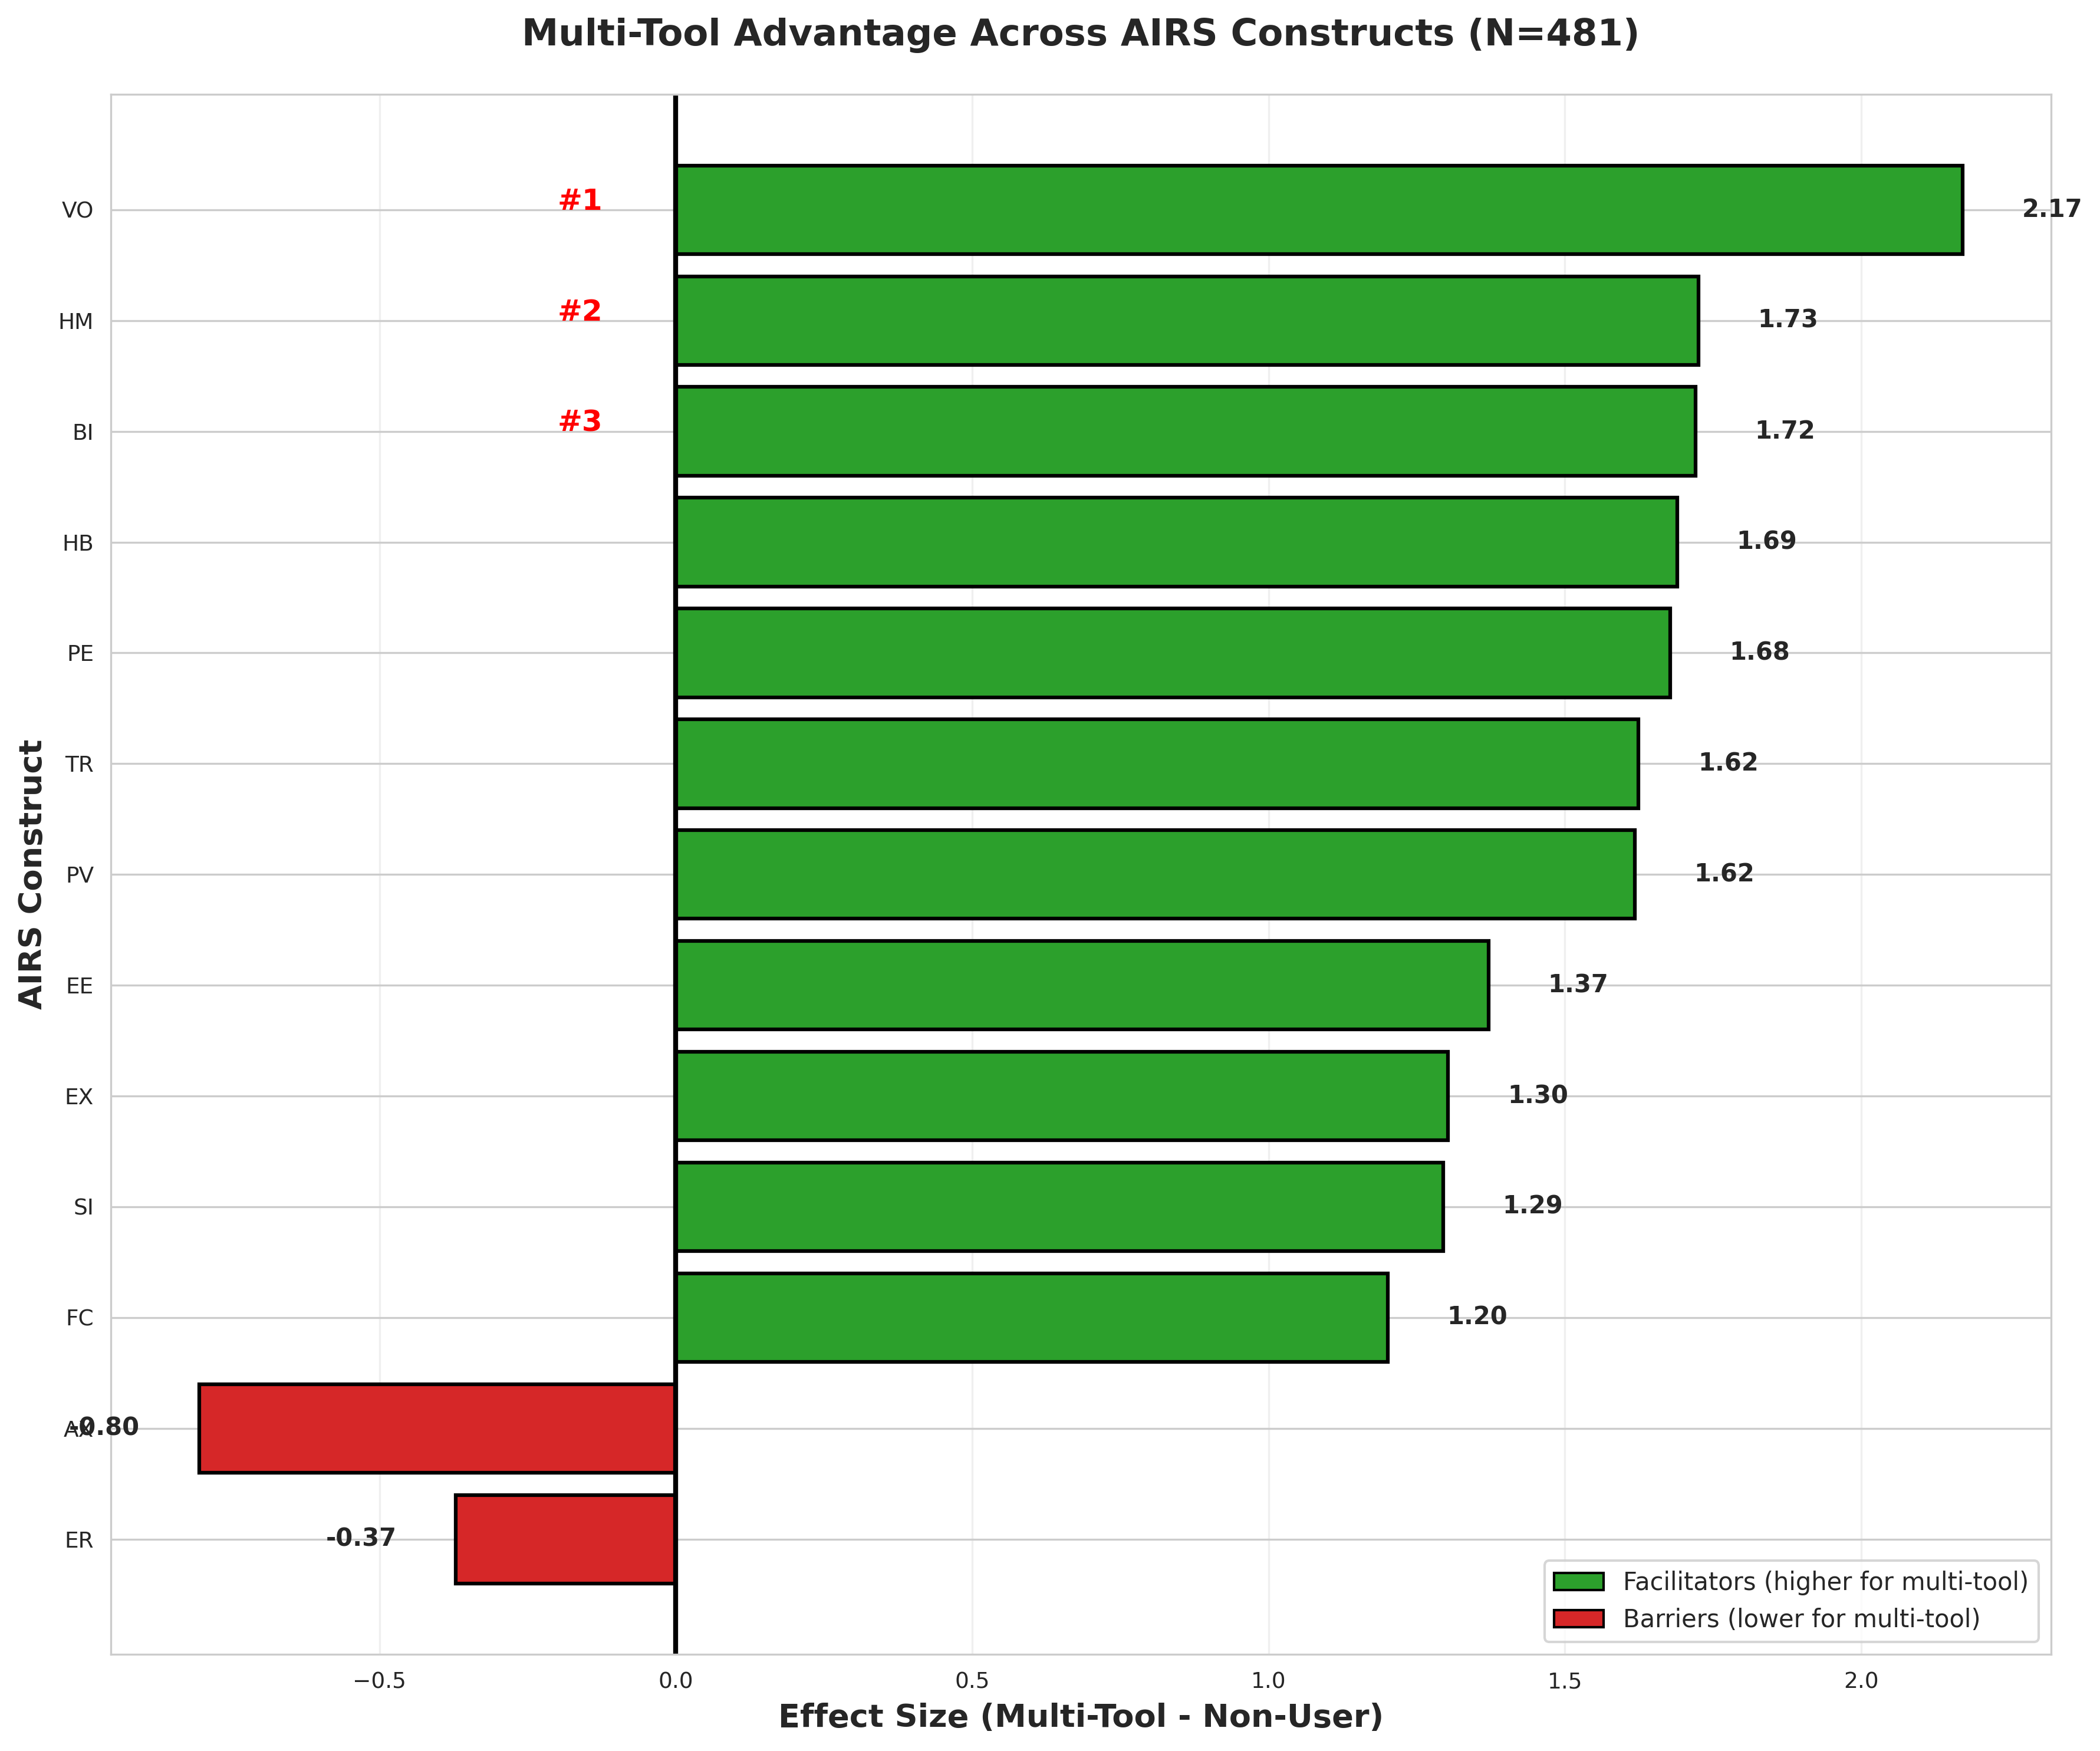


✓ Figure 8 saved: 07_effect_sizes_all_constructs.png

Top Effect Sizes:
  1. VO: Δ=2.17
  2. HM: Δ=1.73
  3. BI: Δ=1.72


In [181]:
# Figure 8: Effect Size Comparison - All AIRS Constructs
# Calculate effect sizes (difference between Multi-Tool and Non-User groups)
effect_sizes = []
construct_names = []

for airs_var, airs_label in zip(airs_constructs, construct_labels):
    if airs_var in df.columns:
        non_user_mean = profile_comparison.loc['Non-User', airs_label]
        multi_tool_mean = profile_comparison.loc['Multi-Tool', airs_label]
        effect = multi_tool_mean - non_user_mean
        effect_sizes.append(effect)
        construct_names.append(airs_label)

# Sort by absolute effect size
sorted_indices = sorted(range(len(effect_sizes)), key=lambda i: abs(effect_sizes[i]), reverse=True)
effect_sizes_sorted = [effect_sizes[i] for i in sorted_indices]
construct_names_sorted = [construct_names[i] for i in sorted_indices]

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Color by direction (positive = green, negative = red)
colors_effect = ['#2ca02c' if e > 0 else '#d62728' for e in effect_sizes_sorted]

bars = ax.barh(construct_names_sorted[::-1], effect_sizes_sorted[::-1], 
               color=colors_effect[::-1], edgecolor='black', linewidth=1.5)
ax.set_xlabel('Effect Size (Multi-Tool - Non-User)', fontsize=13, fontweight='bold')
ax.set_ylabel('AIRS Construct', fontsize=13, fontweight='bold')
ax.set_title(f'Multi-Tool Advantage Across AIRS Constructs (N={len(df)})', 
             fontsize=15, fontweight='bold', pad=20)
ax.axvline(0, color='black', linewidth=2)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for bar, effect, construct in zip(bars, effect_sizes_sorted[::-1], construct_names_sorted[::-1]):
    label_x = effect + (0.1 if effect > 0 else -0.1)
    ha = 'left' if effect > 0 else 'right'
    ax.text(label_x, bar.get_y() + bar.get_height()/2, 
            f'{effect:.2f}', 
            va='center', ha=ha, fontsize=10, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ca02c', edgecolor='black', label='Facilitators (higher for multi-tool)'),
    Patch(facecolor='#d62728', edgecolor='black', label='Barriers (lower for multi-tool)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

# Highlight top 3
top3_y_positions = [len(effect_sizes_sorted) - 1 - i for i in range(min(3, len(effect_sizes_sorted)))]
for i in range(min(3, len(effect_sizes_sorted))):
    y_pos = top3_y_positions[i]
    ax.annotate(f'#{i+1}', xy=(-0.2, y_pos), fontsize=12, fontweight='bold', color='red')

plt.tight_layout()
plt.savefig('../results/plots/07_effect_sizes_all_constructs.png', bbox_inches='tight', dpi=300)
plt.show()

print("\n✓ Figure 8 saved: 07_effect_sizes_all_constructs.png")
print("\nTop Effect Sizes:")
for i in range(min(3, len(construct_names_sorted))):
    construct = construct_names_sorted[i]
    effect = effect_sizes_sorted[i]
    print(f"  {i+1}. {construct}: Δ={effect:.2f}")

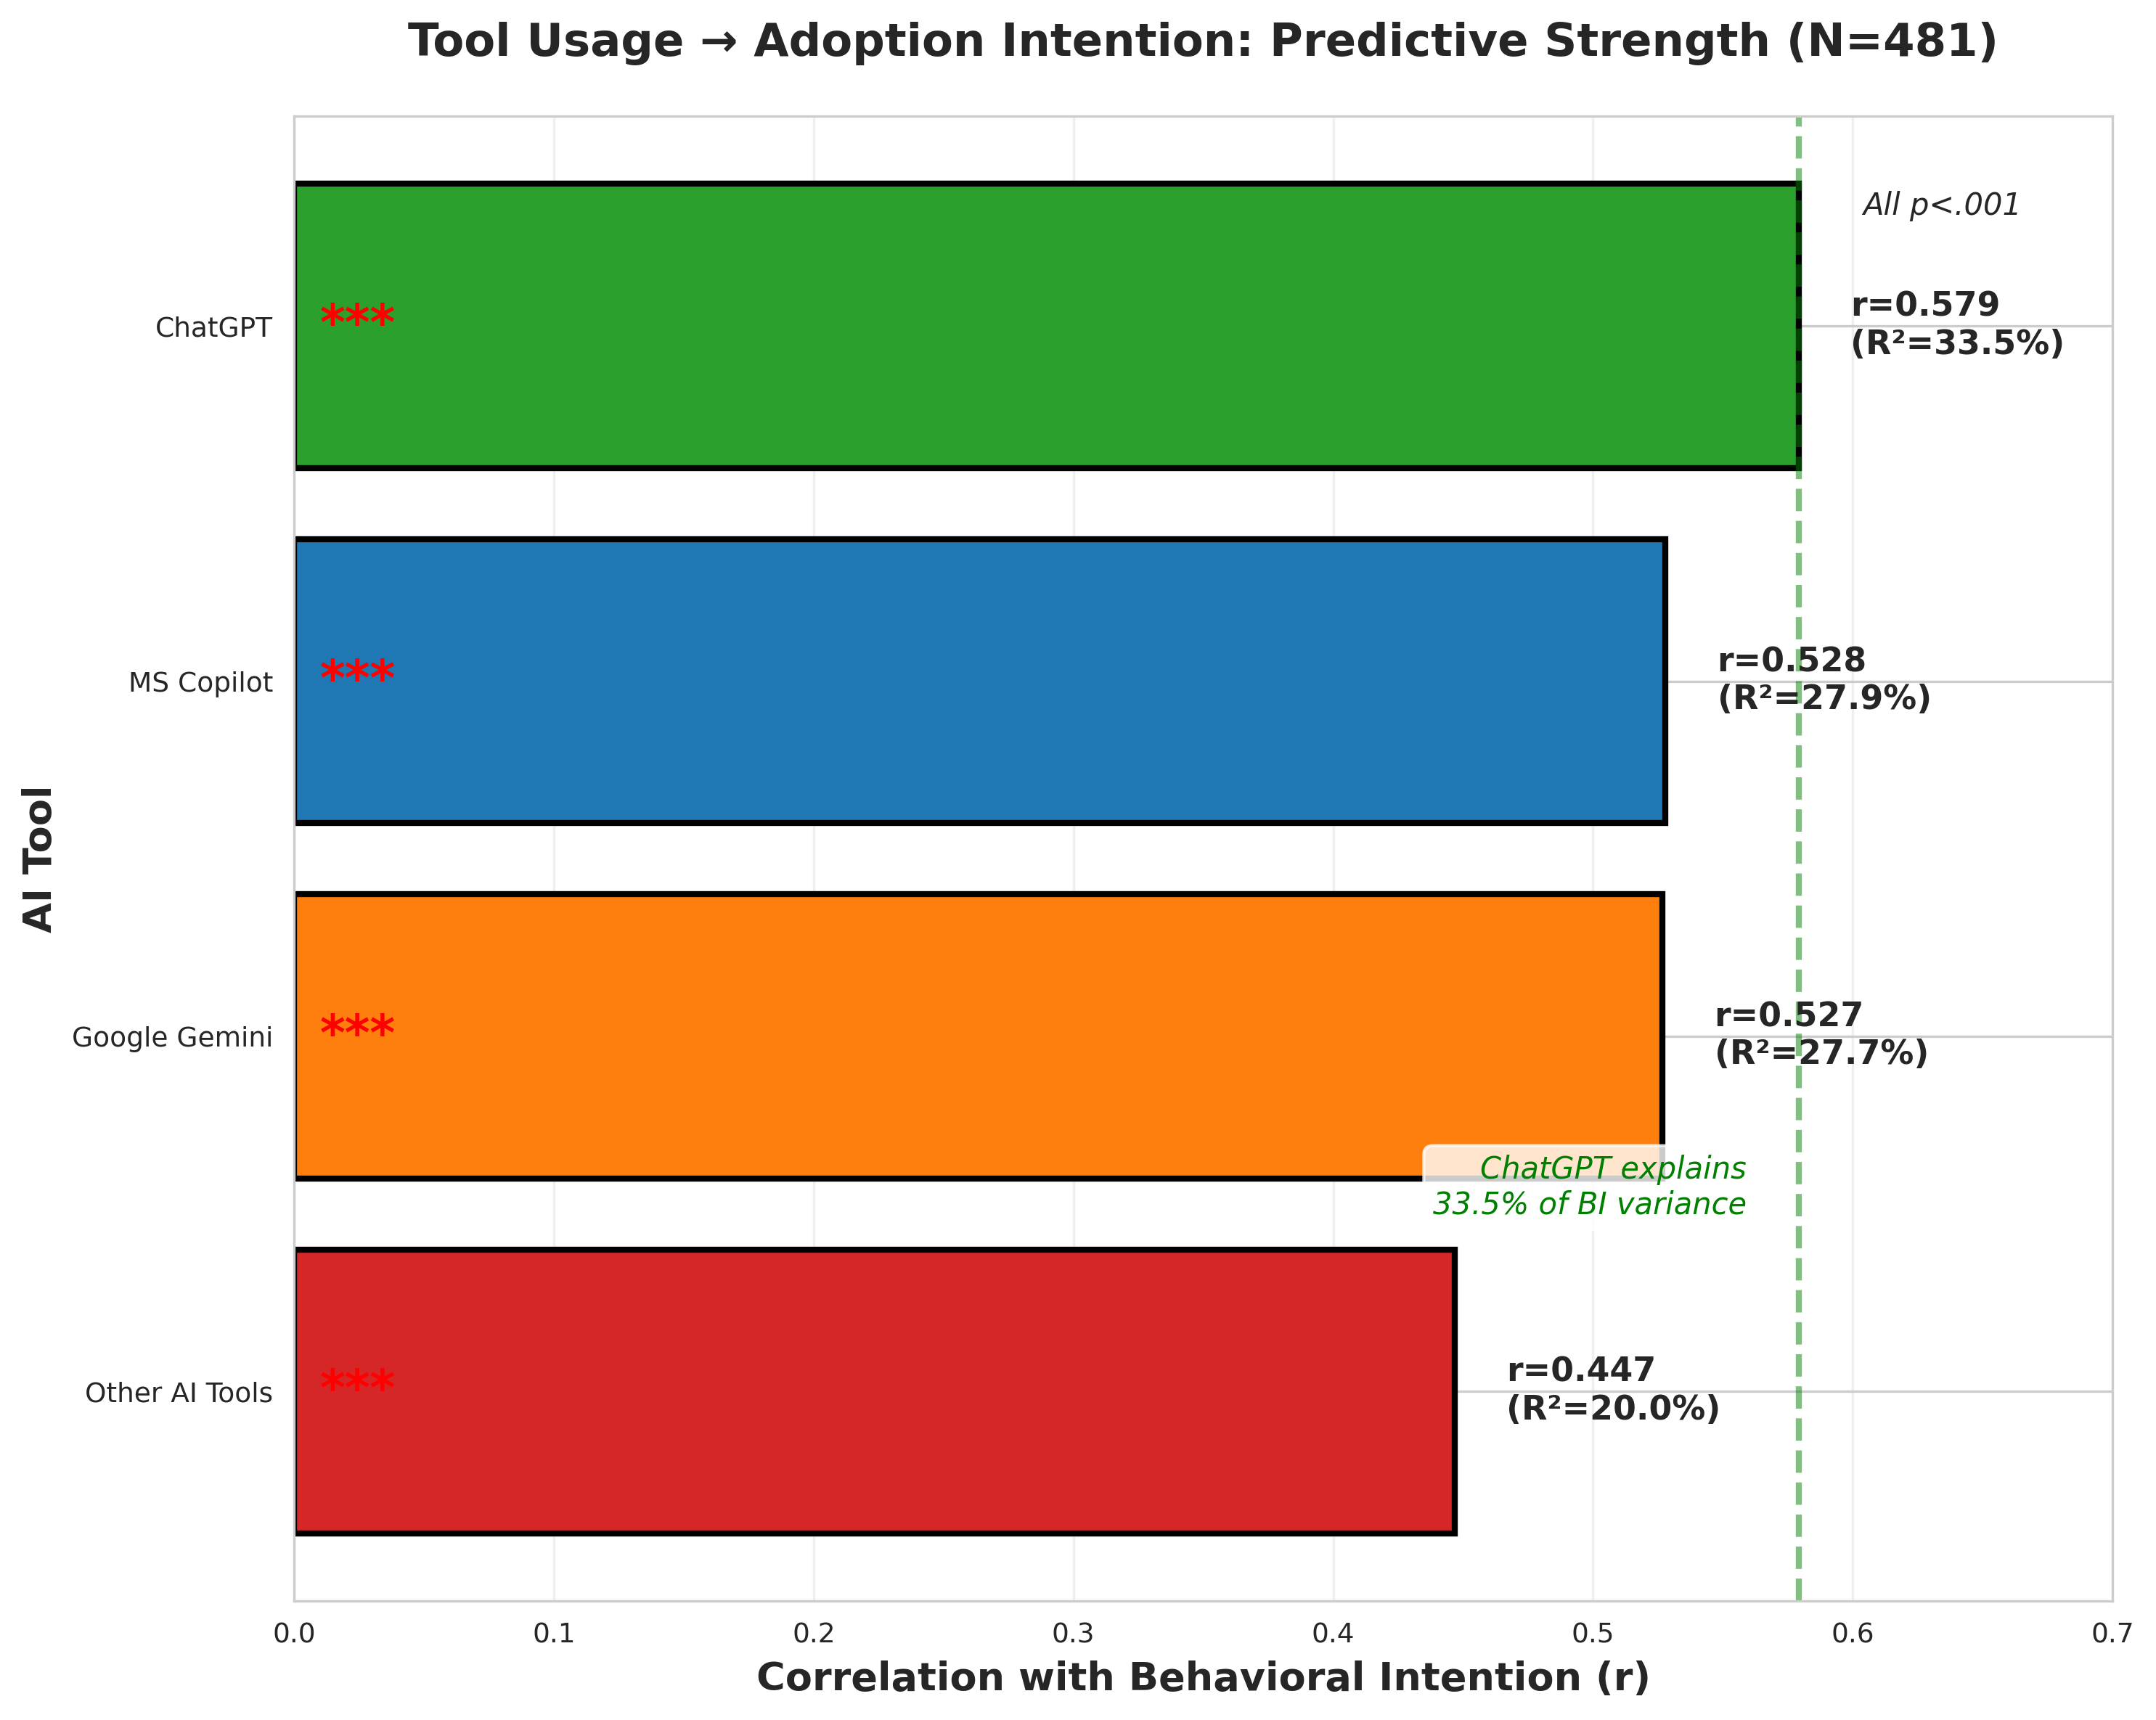


✓ Figure 9 saved: 07_tool_bi_correlations.png

Variance Explained in BI:
  ChatGPT: 33.5%
  MS Copilot: 27.9%
  Google Gemini: 27.7%
  Other AI Tools: 20.0%

ChatGPT advantage: 5.7 percentage points over MS Copilot


In [182]:
# Figure 9: Tool-BI Correlation Comparison
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate BI correlations for all tools
bi_corr_data = []
for tool_var, tool_label in zip(tool_vars, tool_labels):
    if 'BI' in df.columns:
        r, p = stats.pearsonr(df[tool_var].dropna(), df['BI'].dropna())
        bi_corr_data.append((tool_label, r, p))

# Sort by correlation strength
bi_corr_data_sorted = sorted(bi_corr_data, key=lambda x: x[1], reverse=True)
tool_names_corr = [item[0] for item in bi_corr_data_sorted]
bi_corr_values = [item[1] for item in bi_corr_data_sorted]

# Calculate R² (variance explained)
r_squared = [r**2 * 100 for r in bi_corr_values]

# Create bars (use appropriate number of colors)
colors_corr = ['#2ca02c', '#1f77b4', '#ff7f0e', '#d62728'][:len(tool_names_corr)]
bars = ax.barh(tool_names_corr[::-1], bi_corr_values[::-1], 
               color=colors_corr[::-1],
               edgecolor='black', linewidth=2)
ax.set_xlabel('Correlation with Behavioral Intention (r)', fontsize=13, fontweight='bold')
ax.set_ylabel('AI Tool', fontsize=13, fontweight='bold')
ax.set_title(f'Tool Usage → Adoption Intention: Predictive Strength (N={len(df)})', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xlim(0, max(0.7, max(bi_corr_values) + 0.1))
ax.grid(axis='x', alpha=0.3)

# Add correlation and R² labels
for bar, r, r2, tool in zip(bars, bi_corr_values[::-1], r_squared[::-1], tool_names_corr[::-1]):
    ax.text(r + 0.02, bar.get_y() + bar.get_height()/2, 
            f'r={r:.3f}\n(R²={r2:.1f}%)', 
            va='center', fontsize=11, fontweight='bold')

# Highlight top tool advantage
if len(bi_corr_values) > 0:
    ax.axvline(bi_corr_values[0], color='green', linestyle='--', linewidth=2, alpha=0.5)
    ax.text(bi_corr_values[0] - 0.02, 0.5, 
            f'{tool_names_corr[0]} explains\n{r_squared[0]:.1f}% of BI variance', 
            fontsize=10, style='italic', color='green', ha='right', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add significance stars for p<.001
for i, (bar, corr_data) in enumerate(zip(bars, bi_corr_data_sorted[::-1])):
    if corr_data[2] < 0.001:
        ax.text(0.01, bar.get_y() + bar.get_height()/2, '***', 
                va='center', fontsize=16, fontweight='bold', color='red')

# Add significance note
all_sig = all(item[2] < 0.001 for item in bi_corr_data_sorted)
if all_sig:
    ax.text(0.95, 0.95, 'All p<.001', fontsize=10, style='italic', 
            transform=ax.transAxes, ha='right', va='top')

plt.tight_layout()
plt.savefig('../results/plots/07_tool_bi_correlations.png', bbox_inches='tight', dpi=300)
plt.show()

print("\n✓ Figure 9 saved: 07_tool_bi_correlations.png")
print("\nVariance Explained in BI:")
for tool, r2 in zip(tool_names_corr, r_squared):
    print(f"  {tool}: {r2:.1f}%")
if len(tool_names_corr) >= 2:
    print(f"\n{tool_names_corr[0]} advantage: {r_squared[0] - r_squared[1]:.1f} percentage points over {tool_names_corr[1]}")